In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

import time

# Generate synthetic data

First, we create a regular grid of observation points.

In [2]:
sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[0, 2000, 0, 2000],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

Then, we create a low-frequency noise by simulating deeper dipole sources

In [3]:
# deep_dipole_coordinates = (
#     [ 300,  750, 1200, 300, 1200, 1750],  # µm
#     [ 300, 1000, 1700, 1600, 300, 1000],  # µm
#     [-600, -600, -600, -600, -600, -600],  # µm
# )
# deep_dipole_moments = mg.angles_to_vector(
#     inclination=[-90, 90, -90, 90, 90, -90],
#     declination=[0, 0, 0, 0, 0, 0],
#     amplitude=[1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10],
# )

Now create the dipole model that will be used to generate the data.

In [4]:
sourcers1 = 50
sourcers2 = 150
sourcers3 = 10
np.random.seed(3)

dipole_coordinates = (
    np.concatenate([np.random.randint(0, 2000, sourcers1),np.random.randint(0, 2000, sourcers2),np.random.randint(0, 2000, sourcers3)]),  # µm
    np.concatenate([np.random.randint(750, 1250, sourcers1),np.random.randint(0, 2000, sourcers2),np.random.randint(0, 2000, sourcers3)]),  # µm
    np.concatenate([np.random.randint(-20, -1, sourcers1+sourcers2), np.random.randint(-60, -30, sourcers3)]),  # µm
)
dipole_moments = mg.angles_to_vector(
    inclination=np.concatenate([np.random.normal(35, 5, sourcers1),np.random.normal(0, 50, sourcers2), np.random.normal(0, 50, sourcers3)]),
    declination=np.concatenate([np.random.normal(340, 5, sourcers1),np.random.normal(0, 140, sourcers2),np.random.normal(0, 140, sourcers3)]),
    amplitude=np.concatenate([abs(np.random.normal(0, 100, sourcers1))*1.0E-16, abs(np.random.normal(0, 100, sourcers2))*1.0E-15, np.ones(sourcers3)*1.0e-11]),
)

# print(abs(np.random.normal(1.0E-14, 1.0E-12, sourcers)))
print(dipole_coordinates)

(array([1898, 1688, 1273, 1667,  952,  968,  256,  789, 1021,  659, 1738,
        875, 1017, 1705, 1674,  917, 1143, 1446,  480, 1684, 1964,  605,
       1447,  398, 1528, 1562,  337, 1498,  662,  834,  258, 1983, 1340,
        641, 1971,  858, 1605,  872,  622, 1633,  413, 1642, 1176,  507,
        830,  519, 1016, 1195, 1569,  379, 1359,  176, 1829, 1044,  862,
        561, 1429,  383, 1742, 1524, 1564, 1911, 1590, 1024,  704, 1001,
        274, 1396, 1983, 1701,  184, 1976, 1991,  165, 1789, 1710,  545,
        113, 1025, 1877,  117,  887, 1994, 1771, 1916,  996, 1635,  731,
       1936,  511,  848, 1696,  912, 1010,  274, 1867,  183,  864, 1247,
        141, 1445, 1438, 1584, 1981, 1313,  308,  497,  508,  754,    2,
       1180,   36,  858, 1768,  684,  176, 1851,  970,  182, 1520,  484,
       1627,  497,  277,  625, 1848, 1640,  295,  285, 1184, 1712, 1033,
       1057, 1519,  503,  444,  728, 1335,  267, 1236,  906,  368, 1744,
         76,  836, 1324,   44, 1019, 1299,  912,  

In [5]:
# bz_regional = mg.dipole_bz(coordinates, deep_dipole_coordinates, deep_dipole_moments)
bz = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
# data = vd.make_xarray_grid(coordinates, bz+bz_regional, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data = vd.make_xarray_grid(coordinates, bz, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data.x.attrs = {"units": "µm"}
data.y.attrs = {"units": "µm"}
data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}


# Add some random noise to make it more realistic.
noise_std_dev = 50  # nT
data.bz.values += mg.gaussian_noise(noise_std_dev, data.bz.shape, seed=42)
# Add a positive shift to the data 
data.bz.values += 2000 # nT

data

<xarray.Dataset> Size: 16MB
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 8MB 2.013e+03 1.946e+03 ... 2.017e+03 2e+03

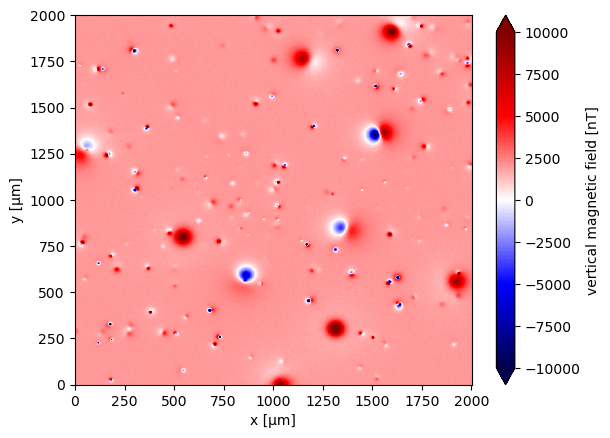

In [6]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

Add a polynomial shift to the data

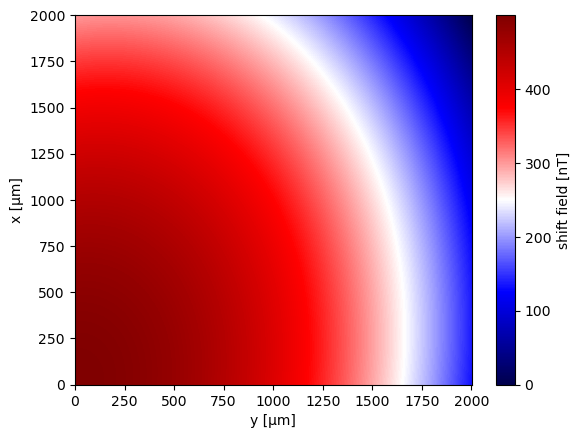

In [7]:
# a, b, c, d, e, f, g = 1, 2, -1, 3, -2, 1, 0.5
# a, b, c, d, e, f, g = 1.0, 0.5, 0.2, -1.0, 0.8, -2.0, 0.3
# pol = (a * data['x']**2 + b * data['y']**2 + c * data['x'] * data['y'] + d * data['x'] + e * data['y'] + f + g * data['y']**2)
# data['poly'] = (pol/pol.values.max())*2000


a, b, c, d, e, f, g = 3, 5, -1, 3, -5, 10, 0.5
pol = (a * data['x']**2 + b * data['y']**2 + c * data['x'] * data['y'] + d * data['x'] + e * data['y'] + f + g * data['y']**2)
data['poly'] = abs((pol/pol.values.max())-(pol/pol.values).max())*500

data.poly.attrs = {"long_name": "shift field", "units": "nT"}


# data.bz.values += data.poly.values 

data.poly.plot.pcolormesh(cmap="seismic")#, vmax=10000, vmin=-10000)

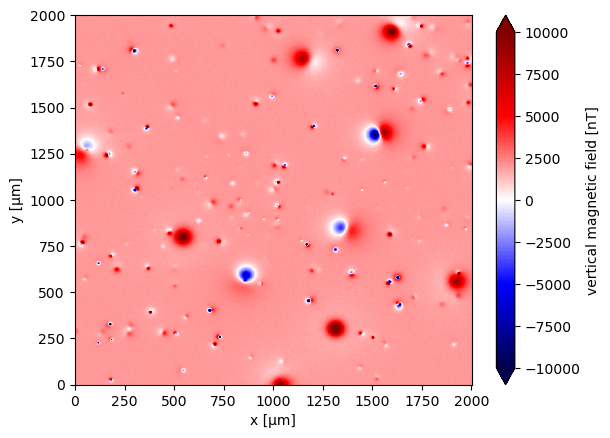

In [8]:
# median = np.median(data.bz.values)
# data.bz.values -= median

data_copy = data.copy(deep=True)
data_copy2 = data_copy.copy(deep=True)

data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Regional Separation

In [9]:
# regional = vd.Trend(degree=1).fit(coordinates, data.bz.values)
# data = data.assign(
#     regional_predicted=regional.predict((data.x, data.y)),
# )
# data.bz.values -= data.regional_predicted.values
# data


data_table = vd.grid_to_table(data)

regional = vd.Trend(degree=1).fit((data_table.x, data_table.y), data.bz.values.ravel())

shape = data.bz.shape
regional_predicted=regional.predict((data_table.x, data_table.y))
regional_predicted = np.reshape(regional_predicted, shape)


data = data.assign(regional_predicted=(("y", "x"), regional_predicted))
data.regional_predicted.attrs = {"long_name": "vertical magnetic field", "units": "nT"}

# data.bz.values -= data.regional_predicted.values

data

<xarray.Dataset> Size: 32MB
Dimensions:             (y: 1001, x: 1001)
Coordinates:
  * x                   (x) float64 8kB 0.0 2.0 4.0 ... 1.998e+03 2e+03
  * y                   (y) float64 8kB 0.0 2.0 4.0 ... 1.998e+03 2e+03
    z                   (y, x) float64 8MB 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0
Data variables:
    bz                  (y, x) float64 8MB 2.013e+03 1.946e+03 ... 2e+03
    poly                (x, y) float64 8MB 500.0 500.0 500.0 ... 0.6662 0.0
    regional_predicted  (y, x) float64 8MB 1.967e+03 1.967e+03 ... 2.044e+03

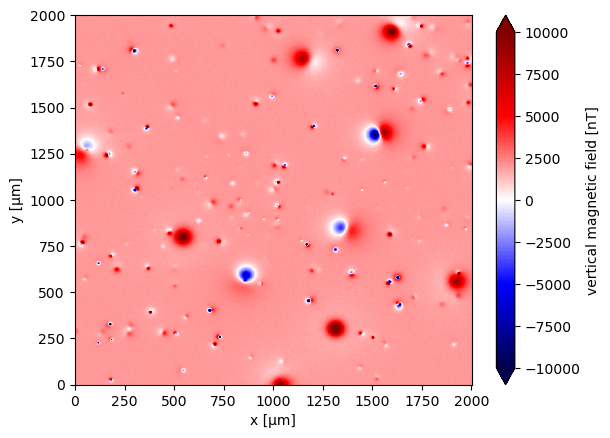

In [10]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [11]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 16MB
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 8MB 2.012e+03 2.01e+03 ... 2.024e+03 2.02e+03

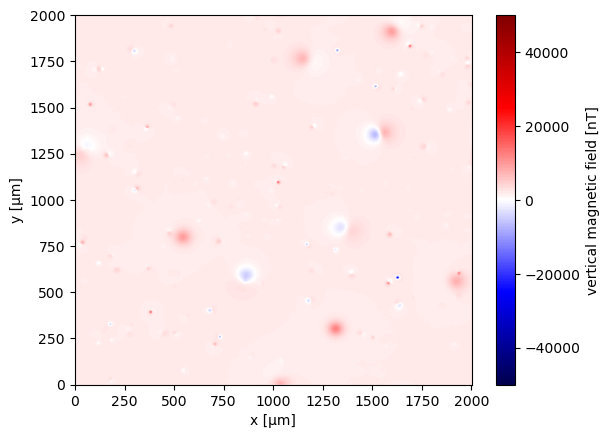

In [12]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [13]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 48MB
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 8MB 2.012e+03 2.01e+03 ... 2.024e+03 2.02e+03
    tga      (y, x) float64 8MB 2.757 2.538 2.04 1.785 ... 4.562 4.003 3.724
    x_deriv  (y, x) float64 8MB -0.8774 -0.6574 -0.5559 ... -1.999 -1.939 -1.933
    y_deriv  (y, x) float64 8MB -1.747 -1.924 -1.915 ... -3.854 -3.296 -2.874
    z_deriv  (y, x) float64 8MB 1.944 1.519 0.4307 0.5901 ... 1.402 1.183 1.367

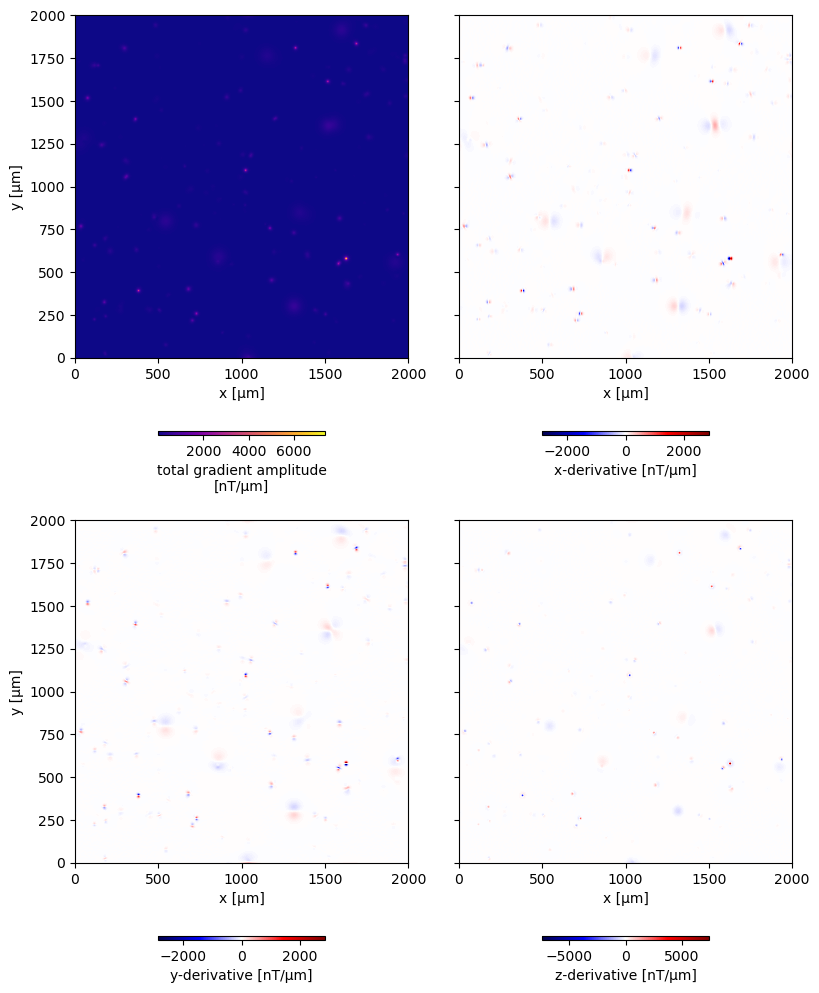

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [15]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

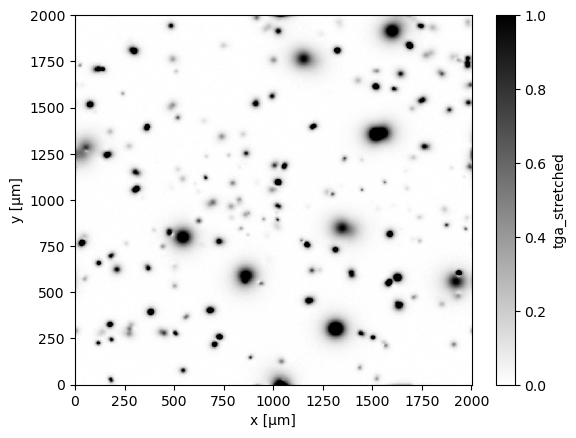

In [16]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [17]:
start_detection_time = time.perf_counter()

windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 150],
    size_increment=1.0,
    threshold=0.09,
    overlap=0.3,
    exclude_border=15
)
# windows
end_detection_time = time.perf_counter()

In [18]:
detection_time = end_detection_time-start_detection_time

print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

121 potential sources detected within 3.0162 seconds


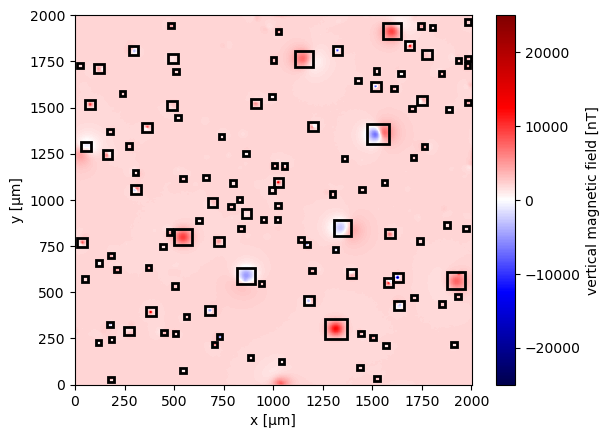

In [19]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion (Standard method)

Run the Euler Deconvolution and the inversion on each window.

In [20]:
start_inversion_time = time.perf_counter()

positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = False # position[2] > 0
    poor_fit = False
    
#     bad_euler = position[2] > 0
#     poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)


end_inversion_time = time.perf_counter()

In [21]:
inversion_time = end_inversion_time-start_inversion_time
print(f"{positions.shape[1]} euler positions and dipole moments estimated within {round(inversion_time, 4)} seconds", )

121 euler positions and dipole moments estimated within 1.6998 seconds


Compare the Euler Deconvolution estimated position on each window to the source true positions.

In [22]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(positions))[1]
z_difference = positions[2] - np.array(dipole_coordinates[2])[closest]
z_difference

array([ 3.33391556e-01,  4.22934523e-01,  3.01034129e-01,  3.25551769e-01,
        4.20407452e-01,  2.99601109e-01,  3.17078935e-01,  4.61193066e-01,
       -4.13215255e+00,  4.33068468e-01,  4.13059361e-01,  4.20749038e-01,
        1.07448195e-01,  4.83491551e-01,  1.49674488e-01,  4.55732455e-01,
        2.70969474e-01,  4.38945182e-01,  1.16716256e-01,  4.53753072e-01,
        1.92255110e-01,  4.32999019e-01,  4.46094052e-01,  3.75385819e-01,
        4.80389724e-01,  1.76389263e-01,  3.10082057e-01,  5.49556295e-01,
        4.43762655e+00,  4.07160993e-01,  3.97775176e-01,  5.65410532e+00,
        6.08803975e-01,  4.23773123e-01,  4.97369604e-01,  5.71685142e-01,
        5.51480943e-01,  5.50158364e-01,  4.13232081e-01,  3.32608629e-01,
        3.42833705e-01,  4.62236939e-01,  3.45912522e-01,  2.00027327e-01,
        4.69577603e-01,  6.19395303e-01,  3.76324983e-01,  2.68915762e-01,
        3.69305080e-01,  4.97273615e-01,  4.88253124e-01,  3.48547948e-01,
        6.17591091e-01, -

In [23]:
# Misfits alculation
direction_misfit = []
magnetic_moment_misfit = []

for estimated, true in zip(estimated_dipole_moments, dipole_moments[closest]):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)

    
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit.append(dir_misfit)
    magnetic_moment_misfit.append(magm_mom_misfit)

/tmp/ipykernel_183238/3758845858.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dir_misfit = float(np.degrees(mplstereonet.angular_distance(


# Iterative Euler deconvolution

In [24]:
import scipy as sp
import numba
import choclo
# @numba.jit(nopython=True, parallel=True)
def goal_function(parameters, obs_data, coordinates):
    constant = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)

    # de, dn = de_orig*mg.MICROMETER_TO_METER, dn_orig*mg.MICROMETER_TO_METER
    de, dn, du = parameters[0], parameters[1], parameters[2]
    mx, my, mz = parameters[3], parameters[4], parameters[5]
    
    e, n, u = coordinates[0], coordinates[1], coordinates[2]
    # print(mx)
    # bz = np.zeros(np.shape(obs_data))
    # for i in numba.prange(e.size):
    distance = choclo.utils.distance_cartesian(
            e,
            n,
            u,
            de,
            dn,
            du,
        )

    bz = constant *(mx*choclo.point.kernel_eu(
            easting_p=e,
            northing_p=n,
            upward_p=u,
            easting_q=de,
            northing_q=dn,
            upward_q=du,
            distance=distance)+
        
          my*choclo.point.kernel_nu(
            easting_p=e,
            northing_p=n,
            upward_p=u,
            easting_q=de,
            northing_q=dn,
            upward_q=du,
            distance=distance)+

          mz*choclo.point.kernel_uu(
            easting_p=e,
            northing_p=n,
            upward_p=u,
            easting_q=de,
            northing_q=dn,
            upward_q=du,
            distance=distance)
                   )
    
    Res = np.linalg.norm( (obs_data)-bz.ravel() )
    return(Res)

In [25]:
import scipy as sp
import numba
import choclo
# @numba.jit(nopython=True, parallel=True)
def goal_function(parameter, obs_data, coordinates, amplitude, x_0, y_0, z_0):
    bz = mg.dipole_bz(coordinates, 
                      ([parameter[0]*x_0], [parameter[1]*y_0], [parameter[2]*z_0]),
                     np.array([parameter[3], parameter[4], parameter[5]])*amplitude
                     )
                   
    
    Res = np.linalg.norm(obs_data-bz.ravel())
    # print(Res)
    return(Res)

In [26]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()


x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
z_deriv_concat = []

estimated_dipole_moments_itr_euler = []

# fitting parameters
calculated_r2_itr_euler = []
calculated_SNR_itr_euler = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)

#################################
for window in rich.progress.track(np.array(windows), total = len(np.array(windows))):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
    else:
        print('piorou')

    estimated_dipole_moments_itr_euler.append(moment)
    
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard
    
#     print(discard.max())
    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])
    calculated_r2_itr_euler = np.append(calculated_r2_itr_euler, r2)
    calculated_SNR_itr_euler = np.append(calculated_SNR_itr_euler, SNR)


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

piorou

In [27]:
np.sum(estimated_dipole_moments_itr_euler, axis=0)

array([ 3.26765285e-12, -1.06407668e-11,  1.94766503e-11])

In [28]:
minimization

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 26.48417269718815
             x: [ 9.998e-01  1.000e+00  1.045e+00  7.619e-02 -7.526e-01
                 -6.814e-01]
           nit: 198
          nfev: 346
 final_simplex: (array([[ 9.998e-01,  1.000e+00, ..., -7.526e-01,
                        -6.814e-01],
                       [ 9.998e-01,  1.000e+00, ..., -7.526e-01,
                        -6.814e-01],
                       ...,
                       [ 9.998e-01,  1.000e+00, ..., -7.526e-01,
                        -6.814e-01],
                       [ 9.998e-01,  1.000e+00, ..., -7.526e-01,
                        -6.814e-01]]), array([ 2.648e+01,  2.648e+01,  2.648e+01,  2.648e+01,
                        2.648e+01,  2.648e+01,  2.648e+01]))

In [29]:
itr_euler_time = end_itr_euler_time-start_itr_euler_time
print(f"Time for the iterative Euler solution and dipole moment estimation: {round(itr_euler_time, 4)} seconds", )

Time for the iterative Euler solution and dipole moment estimation: 182.4364 seconds


In [30]:
df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                  'bz':bz_concat,
                 'z_deriv':z_deriv_concat})

df.head()

x       y     z           bz   z_deriv
0  284.0  1034.0  10.0  1677.917805 -6.667723
1  286.0  1034.0  10.0  1634.813390 -4.856254
2  288.0  1034.0  10.0  1588.538197 -3.770280
3  290.0  1034.0  10.0  1540.454595 -2.992221
4  292.0  1034.0  10.0  1491.684232 -1.776641

In [31]:
positions_itr = np.array([xc_concat, yc_concat, zc_concat])
print(positions_itr[:, 2])

[684.02433413 403.03463595  -5.98314311]


In [32]:
# indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# indexes
# euler_r2_itr_cond

Output()

Output()

[1609.64409975913, 1658.35590024087, 405.64409975913003, 454.35590024086997]

8

[139.64409975913003, 188.35590024086997, 1219.64409975913, 1268.35590024087]

17

[11.644099759130029, 60.35590024086997, 743.6440997591301, 792.3559002408699]

18

[97.64409975913003, 146.35590024086997, 1685.64409975913, 1734.35590024087]

28

[817.2165705248519, 906.7834294751481, 543.2165705248519, 632.7834294751481]

31

[887.6440997591301, 936.3559002408699, 1497.64409975913, 1546.35590024087]

35

[1879.216570524852, 1968.783429475148, 519.2165705248519, 608.7834294751481]

59

[1967.857864376269, 1996.142135623731, 1753.857864376269, 1782.142135623731]

63

[1007.857864376269, 1036.142135623731, 879.857864376269, 908.142135623731]

68

[1285.857864376269, 1314.142135623731, 1017.857864376269, 1046.142135623731]

76

[31.64409975913003, 80.35590024086997, 1263.64409975913, 1312.35590024087]

78

[1027.857864376269, 1056.142135623731, 111.85786437626905, 140.14213562373095]

81

[249.64409975913003, 298.35590024086997, 265.64409975913003, 314.35590024086997]

83

[1555.857864376269, 1584.142135623731, 195.85786437626905, 224.14213562373095]

88

[11.857864376269049, 40.14213562373095, 1715.857864376269, 1744.142135623731]

93

[815.857864376269, 844.142135623731, 987.857864376269, 1016.142135623731]

96

[1751.64409975913, 1800.35590024087, 1761.64409975913, 1810.35590024087]

98

[841.6440997591301, 890.3559002408699, 899.6440997591301, 948.3559002408699]

101

[937.857864376269, 966.142135623731, 881.857864376269, 910.142135623731]

105

[35.85786437626905, 64.14213562373095, 557.857864376269, 586.142135623731]

106

[1917.857864376269, 1946.142135623731, 463.85786437626905, 492.14213562373095]

107

[1837.857864376269, 1866.142135623731, 421.85786437626905, 450.14213562373095]

110

[1725.857864376269, 1754.142135623731, 763.857864376269, 792.142135623731]

115

[1921.857864376269, 1950.142135623731, 1741.857864376269, 1770.142135623731]

117

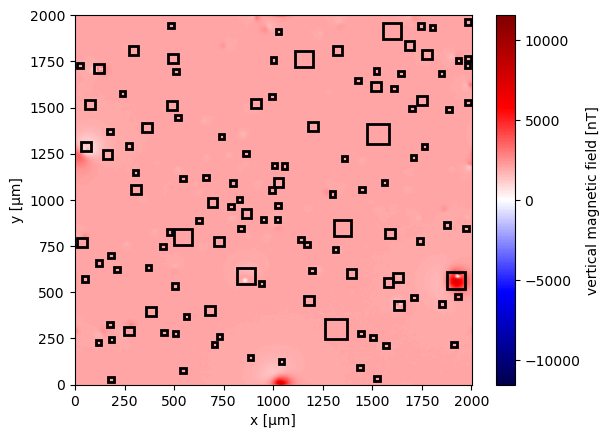

In [33]:
## EULER ENHANCEMENT SECOND STEP
warnings.filterwarnings("ignore")
data_copy = data.copy(deep=True)
euler_r2_itr_cond = calculated_r2_itr_euler>=0.999

zc_concat_temp = list()
xc_concat_temp = list()
yc_concat_temp = list()

estimated_dipole_moments_itr_euler_temp = list()

indexes = np.where(np.array(euler_r2_itr_cond))[0]
# SOURCES WITH R2 >= 0.99 ARE NOT ENHANCED, WE CALCULATE THEIR ANOMALY AND REMOVE THEM FROM THE DATA SET
# for index, window in enumerate(rich.progress.track(np.array(windows)[euler_r2_itr_cond], total=len(np.array(windows)[euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    position = positions_itr[:, index]
    estimated_dipole_moments_itr_euler_temp.append(estimated_dipole_moments_itr_euler[index])
    xc_concat_temp = np.append(xc_concat_temp, position[0])
    yc_concat_temp = np.append(yc_concat_temp, position[1])
    zc_concat_temp = np.append(zc_concat_temp, position[2])  

    
# remove all signals 
position_temp = np.array([xc_concat_temp, yc_concat_temp, zc_concat_temp])
discard = mg.dipole_bz(coordinates, position_temp, estimated_dipole_moments_itr_euler_temp)
data_copy.bz.values -= discard

data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))

###################################################

# ax = plt.subplot(111)
# data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
# for window in windows:
#     rect = matplotlib.patches.Rectangle(
#         xy=[window[0], window[2]],
#         width=window[1] - window[0],
#         height=window[3] - window[2],
#         edgecolor="k",
#         fill=False,
#         linewidth=2,
#     )
#     ax.add_patch(rect)   

##################################################

# SOURCES WITH R2 <= 0.99 ARE ENHANCED
indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# for index, window in enumerate(rich.progress.track(np.array(windows)[~euler_r2_itr_cond], total=len(np.array(windows)[~euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    print(window)
    print(index)
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)



    ## SCIPY MINIMIZATION
    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
        
        if r2 >= calculated_r2_itr_euler[index]:
            estimated_dipole_moments_itr_euler[index] = moment
            positions_itr[:, index] = position
    
    # # store the results with the itr Euler (without interfering sources)
    # print(estimated_dipole_moments_itr_euler[index])
    # print(positions_itr[:, index])
    # estimated_dipole_moments_itr_euler[index] = moment
    # positions_itr[:, index] = position

    # print(moment)
    # print(position)
    # print()
    # #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard

    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))



ax = plt.subplot(111)
data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   


In [34]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(positions_itr))[1]
z_difference_itr = positions_itr[2] - np.array(dipole_coordinates[2])[closest]
z_difference_itr
# euler_r2_itr_cond


array([-2.73008707e-02,  9.88755951e-03,  1.68568906e-02,  6.19295102e-04,
        6.36655164e-03,  4.53013588e-02,  1.07476091e-02,  1.09886457e-01,
       -4.61553488e+00,  7.78871071e-03, -4.62542742e-02,  1.37663828e-03,
        1.41853787e-02,  9.08974549e-02,  6.92584654e-02,  1.08714741e-01,
        5.39887000e-02,  2.03653111e-01, -2.18139584e-01,  5.30954993e-02,
       -1.06816967e-01,  9.87499600e-02,  1.50355222e-02, -9.05800849e-03,
        1.14806713e-01,  1.00482555e-01, -3.83730151e-02,  1.38302567e-01,
        6.23193668e-01,  1.21975545e-01,  4.88348035e-02,  2.34564955e+00,
        3.06297786e-01,  8.26568361e-02,  1.51171236e-01,  1.20669330e-01,
        3.84539542e-02,  2.02813727e-01,  1.92315435e-01,  3.99788137e-02,
        5.80740562e-02,  1.02557645e-01,  5.13467093e-02,  2.10849396e-01,
        1.07213693e-01,  4.52990098e-01,  2.97173589e-01, -8.54820022e-02,
        6.54376701e-02,  1.74230690e-01,  2.51028369e-01,  1.24329787e-01,
        2.48366788e-01,  

# Comparison plots

## Euler comparison

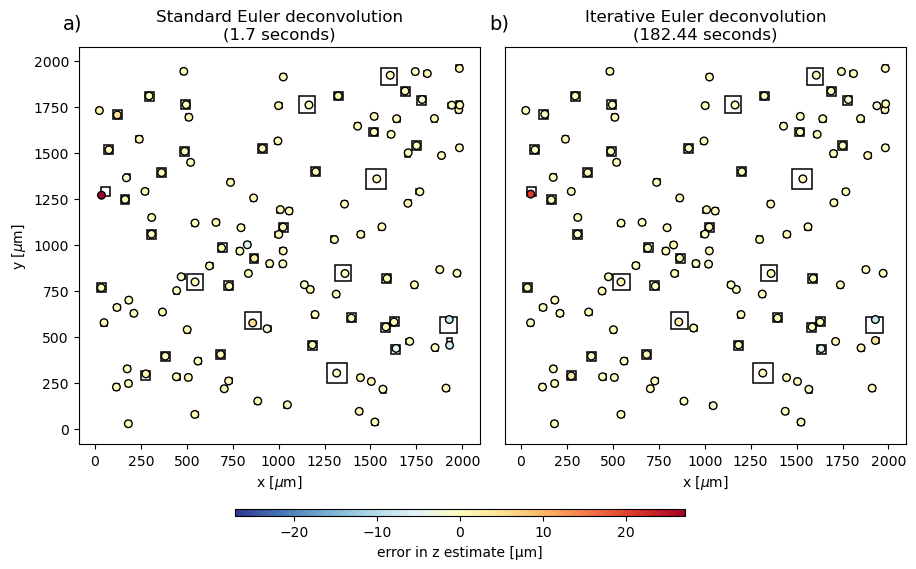

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(9, 9))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

# data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
axes = axes.ravel()

scale = vd.maxabs((z_difference, z_difference_itr))

ax = axes[0]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

ax = axes[1]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions_itr[:2], c=z_difference_itr, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

titles = ([r'Standard Euler deconvolution'   +'\n'+ f'({round(inversion_time, 2)} seconds)', 
           r'Iterative Euler deconvolution' +'\n'+ f'({round(itr_euler_time, 2)} seconds)'])
for ax, letter, title in zip(axes, "a b".split(), titles):
    ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)
    ax.set_aspect("equal")
    ax.set_title(title)
    ax.set_xlabel(r"x [$\mu$m]")

axes[1].set_yticks([])
axes[0].set_ylabel(r"y [$\mu$m]")
plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.25, 0.2, 0.5, 0.0075]))


plt.show()

## Directions and Dipole Moments comparions

### Iterative Euler (withou interf. sources)

In [36]:
# Misfits alculation
direction_misfit_itr_euler = []
magnetic_moment_misfit_itr_euler = []

for estimated, true in zip(estimated_dipole_moments_itr_euler, dipole_moments[closest]):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)

    
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit_itr_euler.append(dir_misfit)
    magnetic_moment_misfit_itr_euler.append(magm_mom_misfit)

In [37]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

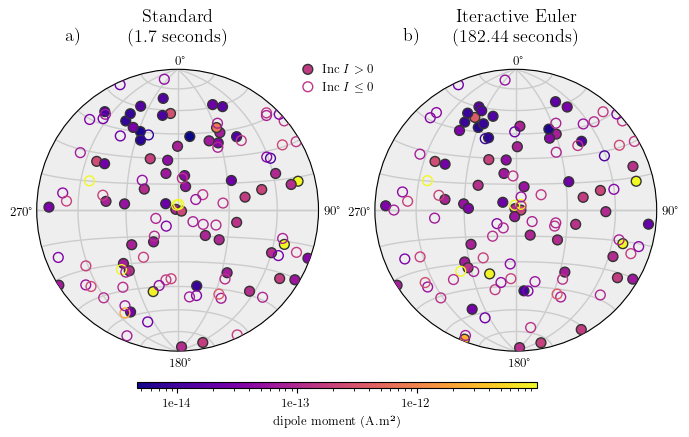

In [38]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(8, 4))
    axes = []

#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     vmin = np.min(estimated)
#     vmax = np.max(estimated)
    
    estimated1 = mg.vector_to_angles(estimated_dipole_moments)[2]
    estimated2 = mg.vector_to_angles(estimated_dipole_moments_itr_euler)[2]

    
    vmin = np.min([np.min(estimated1),np.min(estimated2)])
    vmax = np.max([np.max(estimated1),np.max(estimated2)])
    
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

        
    ## STANDARD METHOD
    ax = fig.add_subplot(1, 2, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
    ax.legend(loc=(0.9, 0.9), frameon=False, handletextpad=0.1, prop = {'size' : 9})
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.015]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )

    
    ## ITERACTIVE METHOD
    ax = fig.add_subplot(1, 2, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs)

    
    ######
    titles = ([r'Standard'+'\n'+ f'({round(inversion_time, 2)} seconds)', 
           'Iteractive Euler'+'\n'+ f'({round(itr_euler_time, 2)} seconds)']) 
 

    for ax, letter, title in zip(axes, "a b".split(), titles):
        ax.text(0.1, 1.1, f"{letter})   ", transform=ax.transAxes, fontsize=13)
        ax.set_title(title+'\n', fontsize=13, loc='center')
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    plt.show()


# Paper's figures 

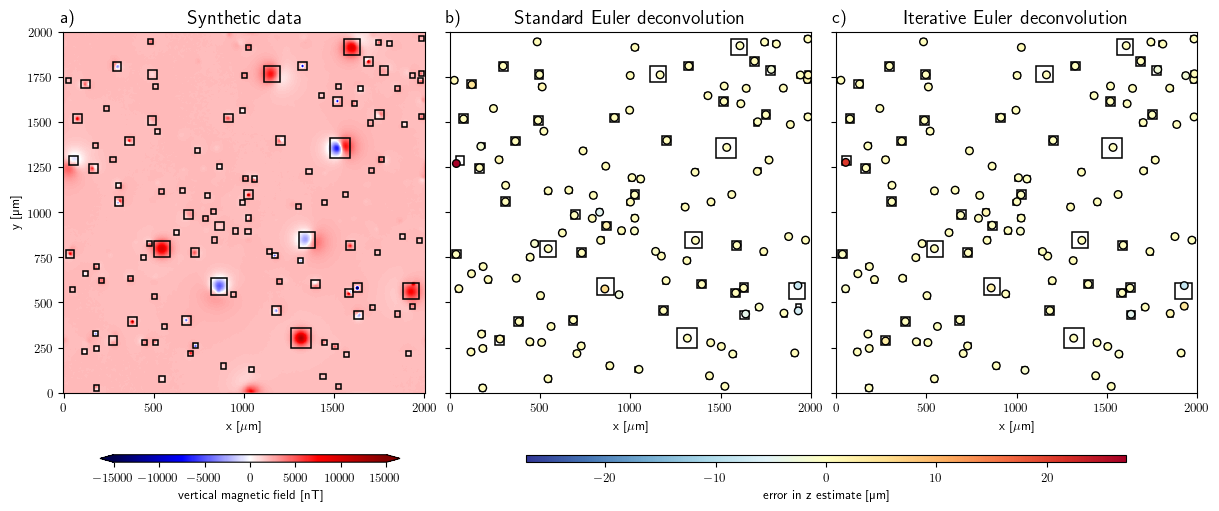

In [39]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_up['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((z_difference, z_difference_itr))

    ax = axes[1]
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

    ax = axes[2]
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions_itr[:2], c=z_difference_itr, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

    titles = ([r'Synthetic data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, -0.00, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.43, -0.00, 0.5, 0.015]))
    fig.savefig(fig_dir / "euler-comparion-synthetic.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


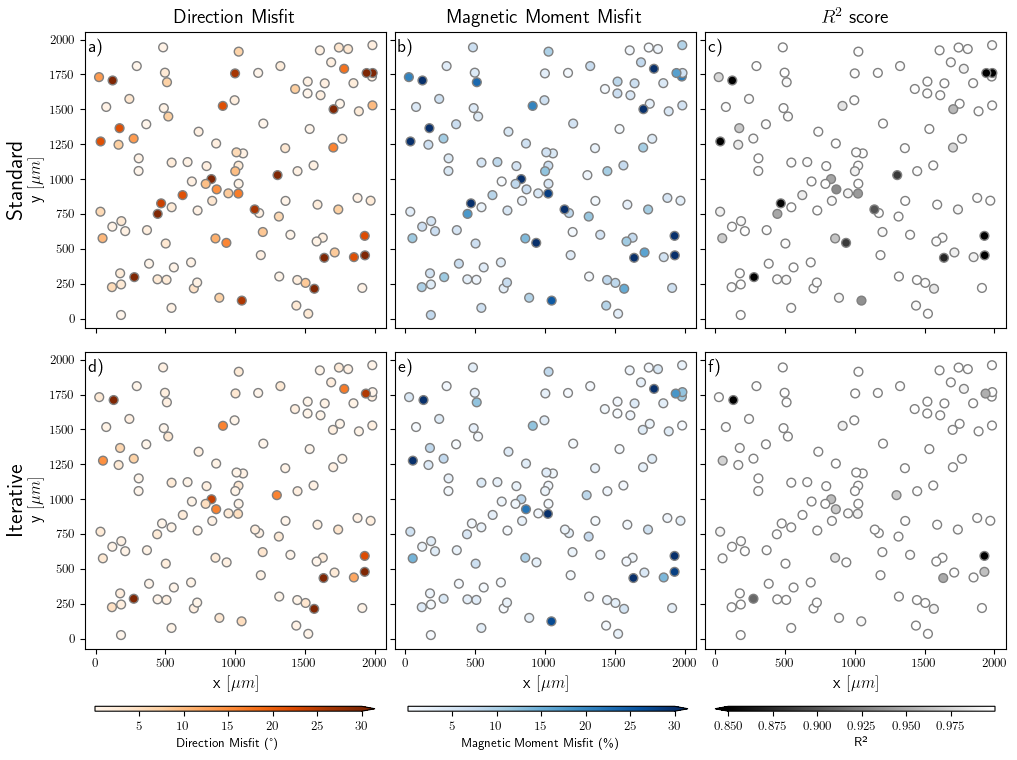

In [40]:
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(2, 3, figsize=(10, 7), sharey="row", sharex='col')
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.05, shrink=0.9)
    
    scale = 30
    ax = axes[0]
    # ax.set_title("Standard", fontsize=16)    
    ax.set_title("Direction Misfit", fontsize=14)    
    tmp = ax.scatter(*positions[:2], c=direction_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')

    ax = axes[3]
    # ax.set_title("Iteractive", fontsize=16)
    tmp = ax.scatter(*positions_itr[:2], c=direction_misfit_itr_euler, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label="Direction Misfit (°)", cax=fig.add_axes([0.085, -0.015, 0.28, 0.007]), extend='max')



    
    scale = 30
    ax = axes[1] 
    ax.set_title("Magnetic Moment Misfit", fontsize=14) 
    tmp = ax.scatter(*positions[:2], c=magnetic_moment_misfit, s=40, cmap="Blues", vmax=scale, edgecolor='gray')

    ax = axes[4] 
    tmp = ax.scatter(*positions_itr[:2], c=magnetic_moment_misfit_itr_euler, s=40, cmap="Blues", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label=r"Magnetic Moment Misfit (\%)", cax=fig.add_axes([0.398, -0.015, 0.28, 0.007]), extend='max')

    
    scale = 0.85
    ax = axes[2] 
    ax.set_title("$R^2$ score", fontsize=14) 
    tmp = ax.scatter(*positions[:2], c=calculated_r2, s=40, cmap="gray", vmin=scale, edgecolor='gray')
    
    ax = axes[5]
    tmp = ax.scatter(*positions_itr[:2], c=calculated_r2_itr_euler, s=40, cmap="gray", vmin=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label="R²", cax=fig.add_axes([0.705, -0.015, 0.28, 0.007]), extend='min')

    for ax, letter in zip(axes, "a b c d e f g h i j k l".split()):
        ax.text(0.01, 0.93, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")

    axes[0].set_ylabel(r'\fontsize{16}{0}\selectfont{Standard}'+'\n'+r'y $[\mu m]$', fontsize=12)
    axes[3].set_ylabel(r'\fontsize{16}{0}\selectfont{Iterative}'+'\n'+r'y $[\mu m]$', fontsize=12)
    
    axes[3].set_xlabel(r'x $[\mu m]$', fontsize=12)
    axes[4].set_xlabel(r'x $[\mu m]$', fontsize=12)
    axes[5].set_xlabel(r'x $[\mu m]$', fontsize=12)

    plt.tight_layout(pad=0, h_pad=0.0, w_pad=0.0)
    fig.savefig(fig_dir / "inversion-comparion-synthetic.png", dpi=300, facecolor='w', bbox_inches='tight')
plt.show()   

In [41]:
data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


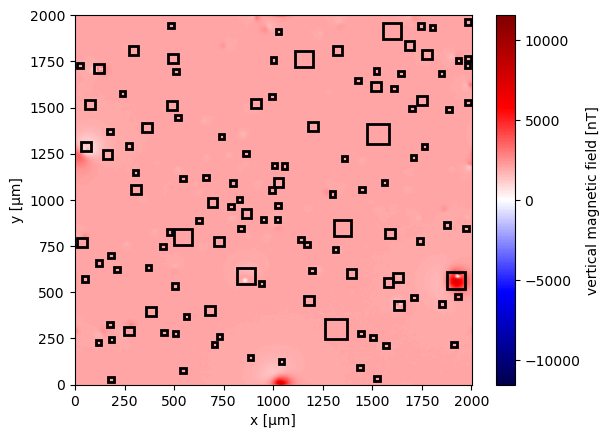

In [42]:
ax = plt.subplot(111)
data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

In [43]:
data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
data_up_copy

<xarray.Dataset> Size: 48MB
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 8MB 1.999e+03 2e+03 ... 1.998e+03 1.999e+03
    tga      (y, x) float64 8MB 0.637 1.002 1.544 1.152 ... 1.127 0.7963 0.5838
    x_deriv  (y, x) float64 8MB 0.4289 0.5108 0.3552 ... -0.18 0.1462 0.2829
    y_deriv  (y, x) float64 8MB -0.2256 -0.8618 -1.168 ... 0.3788 0.001737
    z_deriv  (y, x) float64 8MB 0.4134 0.007256 -0.9454 ... 0.9903 0.6851 0.5107

In [44]:
stretched = skimage.exposure.rescale_intensity(
    data_up_copy.tga, 
    in_range=tuple(np.percentile(data_up_copy.tga, (1, 99))),
)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

In [45]:
start_detection_time = time.perf_counter()

windows_new = mg.detect_anomalies(
    data_up_copy.tga_stretched, 
    size_range=[20,150],
    size_increment=1.3,
    threshold=0.09,
    overlap=0.0,
    exclude_border=15
)
# windows
end_detection_time = time.perf_counter()

In [46]:
detection_time = end_detection_time-start_detection_time
print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

121 potential sources detected within 2.7525 seconds


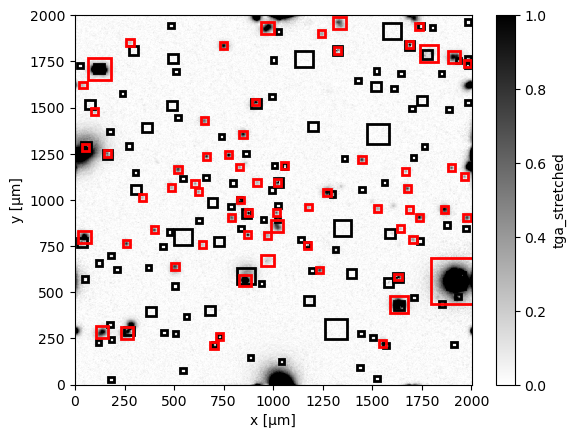

In [47]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

for window in windows_new:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [48]:
def intersects(window1, window2):
    # Verifica se há sobreposição horizontal
    horizontal_overlap = (window1[0] <= window2[1]) and (window2[0] <= window1[1])
    # Verifica se há sobreposição vertical
    vertical_overlap = (window1[2] <= window2[3]) and (window2[2] <= window1[3])
    return horizontal_overlap and vertical_overlap
    


# Remove overlapping windows
non_overlapping_windows = np.copy(windows_new)

for window in windows:
    non_overlapping_windows = [nw for nw in non_overlapping_windows if not intersects(nw, window)]

print("Non-overlapping windows:")
for window in non_overlapping_windows:
    print(window)

Non-overlapping windows:
[ 938.33732969 1001.66267031 1900.33732969 1963.66267031]
[ 757.61522369  794.38477631 1225.61522369 1262.38477631]
[1845.61522369 1882.38477631  931.61522369  968.38477631]
[ 731.61522369  768.38477631 1817.61522369 1854.38477631]
[ 829.61522369  866.38477631 1337.61522369 1374.38477631]
[1719.61522369 1756.38477631  887.61522369  924.38477631]
[241.61522369 278.38477631 745.61522369 782.38477631]
[ 645.61522369  682.38477631 1217.61522369 1254.38477631]
[853.61522369 890.38477631 793.61522369 830.38477631]
[1429.61522369 1466.38477631 1199.61522369 1236.38477631]
[1215.61522369 1252.38477631  601.61522369  638.38477631]
[ 501.61522369  538.38477631 1147.61522369 1184.38477631]
[381.61522369 418.38477631 819.61522369 856.38477631]
[1657.61522369 1694.38477631 1043.61522369 1080.38477631]
[1959.61522369 1996.38477631  885.61522369  922.38477631]
[1302.33732969 1365.66267031 1928.33732969 1991.66267031]
[485.61522369 522.38477631 619.61522369 656.38477631]
[771.

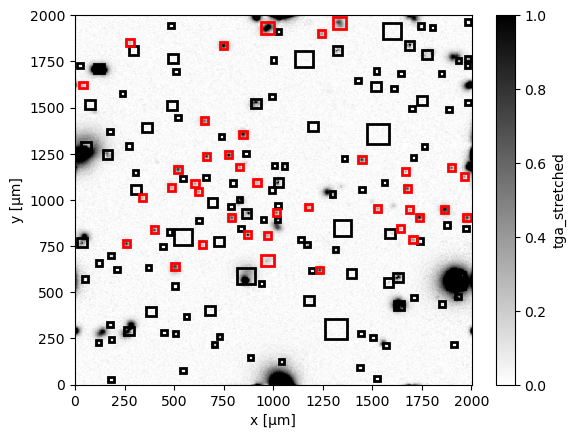

In [49]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [50]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()

data_copy_2 = data_copy.copy(deep=True)
data_up_copy_2 = data_up_copy.copy(deep=True)

positions_itr_enhanced = list(np.copy(positions_itr))
estimated_dipole_moments_itr_euler_enhanced = list(np.copy(estimated_dipole_moments_itr_euler))
windows_enhanced = list(np.copy(windows))
calculated_r2_itr_euler_enhanced = list(np.copy(calculated_r2_itr_euler))

#################################
for window in rich.progress.track(np.array(non_overlapping_windows), total = len(np.array(non_overlapping_windows))):
    anomaly = data_up_copy_2.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
    else:
        print('piorou')


    windows_enhanced.append(window)
    estimated_dipole_moments_itr_euler_enhanced.append(moment)
    for i in range(3):
        positions_itr_enhanced[i]=np.append(positions_itr_enhanced[i], position[i])
    calculated_r2_itr_euler_enhanced.append(r2)
    # estimated_dipole_moments_itr_euler.append(moment)
    print(position)
    print(moment)
    print(mg.vector_to_angles(moment))
    print(r2)
    print()
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy_2.bz.values -= discard
    
#     print(discard.max())
    data_up_copy_2 = (
                hm.upward_continuation(data_copy_2.bz, height_difference)
                .assign_attrs(data_copy_2.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy_2.x, y=data_copy_2.y)
                .assign_coords(z=data_copy_2.z + height_difference)
                   )
    
    
    data_up_copy_2 = data_up_copy_2.assign(mg.data_gradients(data_up_copy_2.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

[ 970.50919386 1932.75629452  -18.46198297]

[-9.45782794e-14 -7.37149619e-14 -6.05056183e-15]

(2.888594841420486, -127.93309625982712, 1.2006479846518658e-13)

0.9963355100165688

[ 776.12924182 1243.37464025   -7.68705513]

[ 2.57306873e-16  6.58736040e-16 -8.03786631e-15]

(84.97182098689122, 21.335961820484457, 8.06891782261102e-15)

0.9985950385086854

[1867.05684759  945.02207046  -16.32149903]

[-2.18385459e-14  3.79393777e-14  2.73879190e-14]

(-32.03178519918793, -29.92545684852117, 5.1637356428724266e-14)

0.999554657775252

[ 754.17583285 1837.00581908  -15.05439292]

[-3.18042348e-14 -2.71647243e-15  2.18837493e-14]

(-34.43377072641972, -94.88191495650447, 3.870125395891364e-14)

0.9994758827644507

[ 848.22403275 1356.04995844  -16.48930033]

[-5.02555275e-16 -1.51658195e-15 -3.46060896e-14]

(87.35666787039807, -161.6661646940143, 3.464295049965462e-14)

0.9991923715892937

[1741.94543589  907.12135939   -9.96971948]

[ 1.44637719e-14  3.21458883e-15 -7.23108923e-15]

(26.014077654997944, 77.46961707542941, 1.6487053445605985e-14)

0.9992680850432325

[257.79644465 766.9333916   -9.74167136]

[-4.32619949e-15  8.73215765e-15 -7.25725858e-15]

(36.675424928329356, -26.355335383402792, 1.2150488936684267e-14)

0.9993142136241268

[ 662.06081355 1238.93089536   -7.73887179]

[-1.81300831e-15  5.28371179e-15 -4.97142909e-15]

(41.66789454909012, -18.9387127497434, 7.477948691550475e-15)

0.9984172600050704

[871.90451766 813.18101972  -3.04259309]

[-6.32733427e-16  1.97660688e-15 -1.63330333e-15]

(38.20199072297413, -17.75043583975988, 2.6410236870315024e-15)

0.9978503494121588

[1446.68390734 1221.5493082    -9.69223196]

[-1.72750670e-15  7.62871569e-15 -7.41263790e-15]

(43.46129631592204, -12.759320452414844, 1.0776306561338722e-14)

0.9967367889716744

[1236.64982883  621.45513207  -14.32247535]

[ 8.21367429e-15  3.27089096e-15 -1.87274214e-14]

(64.72855874947294, 68.28631348091817, 2.0709405685112056e-14)

0.9956673215729155

[ 519.28479577 1170.05720706  -14.35112447]

[-4.93484318e-15  1.65194682e-14 -1.62592530e-14]

(43.32170607614586, -16.63240758883301, 2.3698287129817382e-14)

0.9977550360742136

[397.78039366 840.11451114  -7.7829659 ]

[-3.05175743e-15  6.11448503e-15 -3.96234806e-15]

(30.10603197657921, -26.523918047290547, 7.89938938600557e-15)

0.9978056215240177

[1674.03267657 1066.09429339   -9.94063356]

[-3.25619754e-15  7.55004421e-15 -6.81727788e-15]

(39.662872258549385, -23.32966300552283, 1.0680883283721548e-14)

0.9962041688680948

[1976.19832224  900.02422136  -11.05490819]

[-5.70578295e-15 -1.45630342e-14 -5.71930819e-15]

(20.08562136016167, -158.60480125870322, 1.6653780626025838e-14)

0.9988396990143982

[1334.78996964 1956.81701576  -20.03738406]

[ 2.56601090e-14 -6.84469854e-14 -1.52897343e-14]

(11.813971839621885, 159.44946683373266, 7.468070012610587e-14)

0.9991988736812397

[505.09668278 632.41170068 -14.55372157]

[-2.65467403e-15 -3.44526129e-14 -5.98674223e-15]

(9.829144371835255, -175.5938996699176, 3.5069515463241156e-14)

0.9853272175854197

[788.24519984 907.94187515 -13.86111049]

[-6.34023103e-15  1.31818001e-14 -1.20065739e-14]

(39.380255565964795, -25.686796152576353, 1.89239583448639e-14)

0.998283669771006

[ 647.44850651 1429.22172959  -16.55518422]

[-1.64465544e-14  1.92270549e-15 -1.90589513e-14]

(49.01564132324692, -83.33203085914188, 2.5247367652805428e-14)

0.9989491389654032

[1898.0465686  1176.40744011   -6.51634964]

[-1.14491231e-15  3.57328179e-15 -2.40136442e-15]

(32.618621146144, -17.765935973176035, 4.45485331269857e-15)

0.9964132142530873

[1015.67171269  933.30069087   -5.963376  ]

[-8.05562708e-16  4.07363628e-15 -1.26408003e-15]

(16.93090748072969, -11.185937128896267, 4.3406614889301385e-15)

0.9636944626630407

[1704.01628089  788.94808624  -12.30072671]

[-3.78111967e-15  6.96254149e-15 -5.63988984e-15]

(35.444710556844335, -28.504881354209214, 9.725338423722743e-15)

0.9911862226399492

[ 621.15748824 1046.92035852   -8.40595529]

[-1.94146851e-15  3.78697248e-15 -2.50557343e-15]

(30.488110869166896, -27.14286910643611, 4.938457124272951e-15)

0.9961186730639987

[1247.78957261 1899.9129451   -18.25285717]

[ 2.00503420e-14  3.28188199e-15 -1.26299888e-14]

(31.866797939282314, 80.70413952297952, 2.3922867307429046e-14)

0.9974608453658428

[ 829.26315702 1181.53788363   -7.74123607]

[-2.19882087e-15  2.85958580e-15 -1.83822351e-15]

(27.00318460187852, -37.55775836320535, 4.0485935582039624e-15)

0.9722965759964504

[1528.62582033  956.45361147  -14.87451577]

[-3.26827837e-15  9.26529025e-15 -7.70952434e-15]

(38.12121109804253, -19.43000379894885, 1.248855525727866e-14)

0.993926409621157

[ 604.99166971 1090.96375253   -6.28009305]

[-1.07444917e-15  2.05230654e-15 -1.40091564e-15]

(31.163127374360222, -27.633518839645358, 2.70720663825631e-15)

0.9927939692194035

[969.38566386 810.73155743 -17.56712117]

[-5.45482713e-16  1.36956237e-14 -1.22238592e-14]

(41.7275532027361, -2.280826858966358, 1.8365467445361023e-14)

0.9900612069708977

[1175.45708018  965.91312839  -12.84428316]

[-2.26368263e-15  7.13766471e-15 -4.43211480e-15]

(30.621022830788984, -17.59622208638074, 8.701388288926276e-15)

0.9957142405835823

[ 486.57864088 1070.10000549  -15.65479578]

[ 6.44541095e-15 -4.56057327e-15  9.17984432e-15]

(-49.300743251125446, 125.2820430283411, 1.210833153706298e-14)

0.9558136856888585

[1963.5157011  1127.07579067   -6.67333853]

[-1.08775922e-15  1.69642405e-16 -1.78966548e-15]

(58.402356010198154, -81.13579386938801, 2.101166620759028e-15)

0.7828965997965626

[1687.74412959  949.65827357   -9.18705908]

[-6.67831644e-16  3.71220587e-15 -1.88984331e-15]

(26.612955008853962, -10.19851069736213, 4.2187651326106695e-15)

0.9934010632105941

[ 916.90750305 1100.10208757  -16.94067017]

[-5.30822336e-15  1.31737931e-14 -7.98782319e-15]

(29.3535208401206, -21.94638431784477, 1.629513362475884e-14)

0.9956174185667249

[1669.21209929 1160.973517     -9.9167332 ]

[-2.71157940e-15  3.72419302e-15 -1.60588302e-15]

(19.218166890721704, -36.05830711541417, 4.8786408710458455e-15)

0.9576090515464896

[ 335.6761625  1016.3333494   -14.86592087]

[-4.18170988e-15  5.99812610e-15 -5.74092911e-15]

(38.13709980874431, -34.883028176188624, 9.296369254647536e-15)

0.9901924017350605

[  34.39959359 1625.81613676  -18.94333509]

[-9.63693039e-15  1.05349380e-14 -1.16185024e-14]

(39.136849857533655, -42.45099966017089, 1.840774141862637e-14)

0.9913742751676566

[1642.29896102  847.39599025   -4.67158619]

[-6.24575843e-16  1.16217477e-15 -4.19998467e-16]

(17.657930217645728, -28.254468595598084, 1.384609653944679e-15)

0.9750577741109339

[ 273.66686746 1848.87857229  -14.34032874]

[4.88026333e-15 8.06303587e-15 2.77522089e-15]

(-16.40732765140105, 31.184999516624448, 9.825037848452311e-15)

0.9944770950481331

[640.22091651 763.19267422 -18.34158309]

[-4.54890607e-15  1.24846156e-14 -7.62291656e-15]

(29.842460762050667, -20.019763878611545, 1.5318845559656206e-14)

0.9910989652497944

[975.697199   672.51209241 -23.56374457]

[ 3.27136034e-14  1.32047704e-14 -2.32448686e-15]

(3.769788302298034, 68.01864740108353, 3.535461846704342e-14)

0.9677462885361613

In [51]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(positions_itr_enhanced))[1]
z_difference_itr_enhanced = positions_itr_enhanced[2] - np.array(dipole_coordinates[2])[closest]
z_difference_itr_enhanced

array([-2.73008707e-02,  9.88755951e-03,  1.68568906e-02,  6.19295102e-04,
        6.36655164e-03,  4.53013588e-02,  1.07476091e-02,  1.09886457e-01,
       -4.61553488e+00,  7.78871071e-03, -4.62542742e-02,  1.37663828e-03,
        1.41853787e-02,  9.08974549e-02,  6.92584654e-02,  1.08714741e-01,
        5.39887000e-02,  2.03653111e-01, -2.18139584e-01,  5.30954993e-02,
       -1.06816967e-01,  9.87499600e-02,  1.50355222e-02, -9.05800849e-03,
        1.14806713e-01,  1.00482555e-01, -3.83730151e-02,  1.38302567e-01,
        6.23193668e-01,  1.21975545e-01,  4.88348035e-02,  2.34564955e+00,
        3.06297786e-01,  8.26568361e-02,  1.51171236e-01,  1.20669330e-01,
        3.84539542e-02,  2.02813727e-01,  1.92315435e-01,  3.99788137e-02,
        5.80740562e-02,  1.02557645e-01,  5.13467093e-02,  2.10849396e-01,
        1.07213693e-01,  4.52990098e-01,  2.97173589e-01, -8.54820022e-02,
        6.54376701e-02,  1.74230690e-01,  2.51028369e-01,  1.24329787e-01,
        2.48366788e-01,  

In [52]:
# Misfits alculation
direction_misfit_itr_euler_enhanced = []
magnetic_moment_misfit_itr_euler_enhanced = []

for estimated, true in zip(estimated_dipole_moments_itr_euler_enhanced, dipole_moments[closest]):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)

    
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit_itr_euler_enhanced.append(dir_misfit)
    magnetic_moment_misfit_itr_euler_enhanced.append(magm_mom_misfit)

/tmp/ipykernel_183238/2222737513.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dir_misfit = float(np.degrees(mplstereonet.angular_distance(


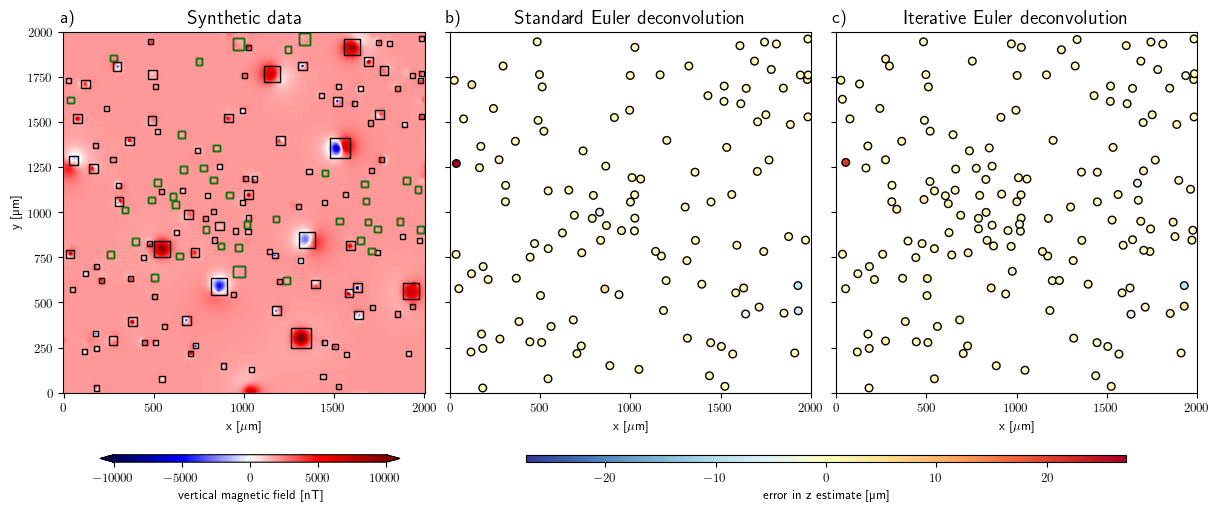

In [53]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_up['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-10000, vmax=10000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_enhanced:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)

    for window in non_overlapping_windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="g",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((z_difference))

    ax = axes[1]
    # for window in windows:
    #     rect = matplotlib.patches.Rectangle(
    #         xy=[window[0], window[2]],
    #         width=window[1] - window[0],
    #         height=window[3] - window[2],
    #         edgecolor="k",
    #         fill=False,
    #         linewidth=1.1,
    #     )
    #     ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

    ax = axes[2]
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=z_difference_itr_enhanced, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

    titles = ([r'Synthetic data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, -0.00, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.43, -0.00, 0.5, 0.015]))
    fig.savefig(fig_dir / "euler-comparion-synthetic.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


/tmp/ipykernel_183238/389122893.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0, h_pad=0.0, w_pad=0.0)


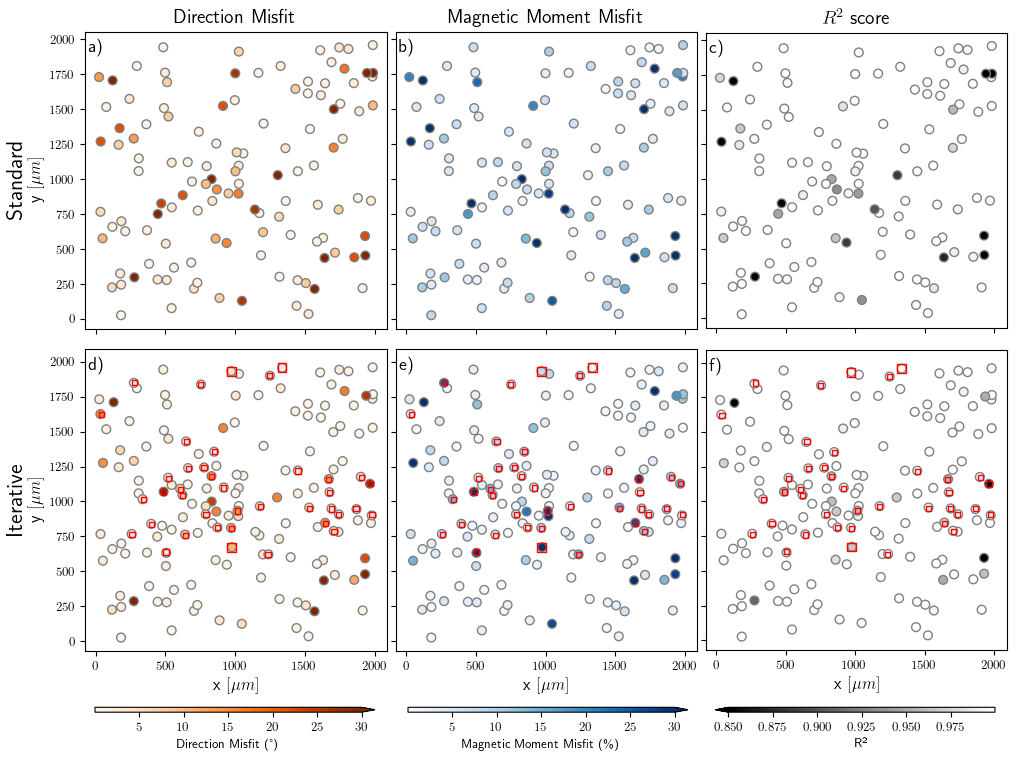

In [54]:
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(2, 3, figsize=(10, 7), sharey="row", sharex='col')
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.05, shrink=0.9)
    
    scale = 30
    ax = axes[0]
    # ax.set_title("Standard", fontsize=16)    
    ax.set_title("Direction Misfit", fontsize=14)    
    tmp = ax.scatter(*positions[:2], c=direction_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')

    ax = axes[3]
    # ax.set_title("Iteractive", fontsize=16)
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=direction_misfit_itr_euler_enhanced, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label="Direction Misfit (°)", cax=fig.add_axes([0.085, -0.015, 0.28, 0.007]), extend='max')



    
    scale = 30
    ax = axes[1] 
    ax.set_title("Magnetic Moment Misfit", fontsize=14) 
    tmp = ax.scatter(*positions[:2], c=magnetic_moment_misfit, s=40, cmap="Blues", vmax=scale, edgecolor='gray')

    ax = axes[4] 
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=magnetic_moment_misfit_itr_euler_enhanced, s=40, cmap="Blues", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label=r"Magnetic Moment Misfit (\%)", cax=fig.add_axes([0.398, -0.015, 0.28, 0.007]), extend='max')

    
    scale = 0.85
    ax = axes[2] 
    ax.set_title("$R^2$ score", fontsize=14) 
    tmp = ax.scatter(*positions[:2], c=calculated_r2, s=40, cmap="gray", vmin=scale, edgecolor='gray')
    
    ax = axes[5]
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=calculated_r2_itr_euler_enhanced, s=40, cmap="gray", vmin=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label="R²", cax=fig.add_axes([0.705, -0.015, 0.28, 0.007]), extend='min')

    for ax, letter in zip(axes, "a b c d e f g h i j k l".split()):
        ax.text(0.01, 0.93, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")

        if ax == axes[-1] or ax == axes[-2] or ax == axes[-3]:
            for window in non_overlapping_windows:
                rect = matplotlib.patches.Rectangle(
                    xy=[window[0], window[2]],
                    width=window[1] - window[0],
                    height=window[3] - window[2],
                    edgecolor="r",
                    fill=False,
                    linewidth=1,
                )
                ax.add_patch(rect)

    axes[0].set_ylabel(r'\fontsize{16}{0}\selectfont{Standard}'+'\n'+r'y $[\mu m]$', fontsize=12)
    axes[3].set_ylabel(r'\fontsize{16}{0}\selectfont{Iterative}'+'\n'+r'y $[\mu m]$', fontsize=12)
    
    axes[3].set_xlabel(r'x $[\mu m]$', fontsize=12)
    axes[4].set_xlabel(r'x $[\mu m]$', fontsize=12)
    axes[5].set_xlabel(r'x $[\mu m]$', fontsize=12)

    plt.tight_layout(pad=0, h_pad=0.0, w_pad=0.0)
    # fig.savefig(fig_dir / "inversion-comparion-synthetic.png", dpi=300, facecolor='w', bbox_inches='tight')
plt.show()   

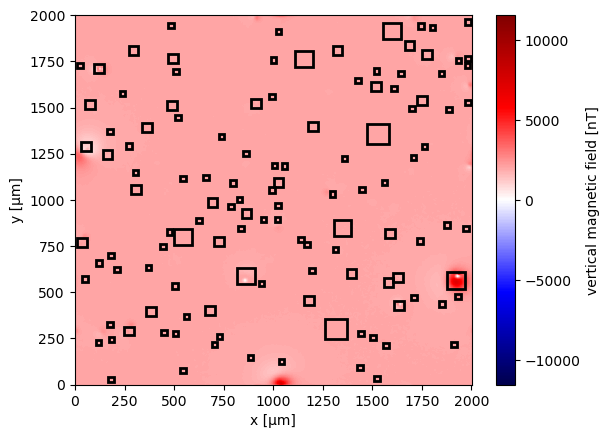

In [55]:
ax = plt.subplot(111)
data_up_copy_2.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

<>:32: DeprecationWarning: invalid escape sequence '\m'
<>:58: DeprecationWarning: invalid escape sequence '\m'
<>:86: DeprecationWarning: invalid escape sequence '\m'
<>:114: DeprecationWarning: invalid escape sequence '\m'
<>:115: DeprecationWarning: invalid escape sequence '\m'
<>:195: DeprecationWarning: invalid escape sequence '\c'
<>:197: DeprecationWarning: invalid escape sequence '\c'
<>:199: DeprecationWarning: invalid escape sequence '\c'
<>:201: DeprecationWarning: invalid escape sequence '\c'
<>:203: DeprecationWarning: invalid escape sequence '\c'
<>:206: DeprecationWarning: invalid escape sequence '\g'
<>:207: DeprecationWarning: invalid escape sequence '\g'
<>:32: DeprecationWarning: invalid escape sequence '\m'
<>:58: DeprecationWarning: invalid escape sequence '\m'
<>:86: DeprecationWarning: invalid escape sequence '\m'
<>:114: DeprecationWarning: invalid escape sequence '\m'
<>:115: DeprecationWarning: invalid escape sequence '\m'
<>:195: DeprecationWarning: invalid e

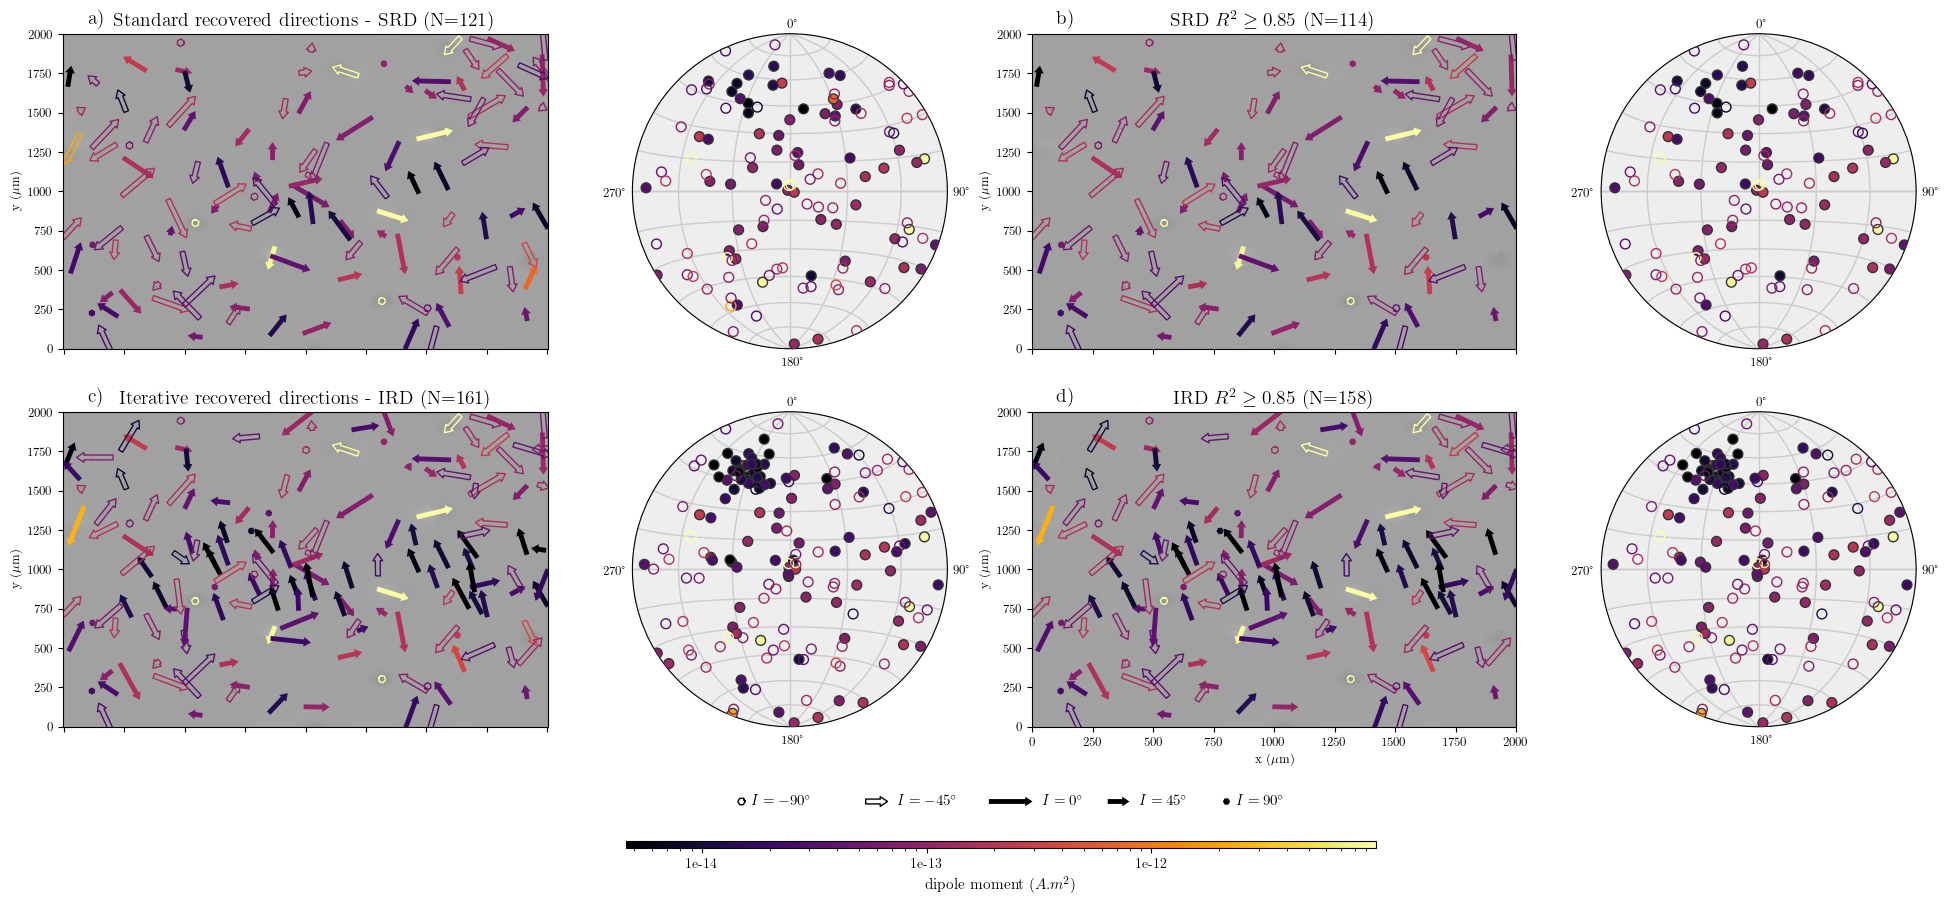

In [56]:
import warnings
warnings.filterwarnings('ignore')

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    
#     clb = fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
#         format="%.0g",
# #         label="dipole moment (A.m²)",
#         orientation="horizontal"
#     )
    
#     clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
#     clb.ax.tick_params(labelsize=10)


    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions_itr_enhanced)[0][pos_filter], 
                                  np.array(positions_itr_enhanced)[1][pos_filter], 
                                  np.array(positions_itr_enhanced)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler_enhanced, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler_enhanced).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq 0.85$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq 0.85$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    fig.savefig(fig_dir / "synthetic-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

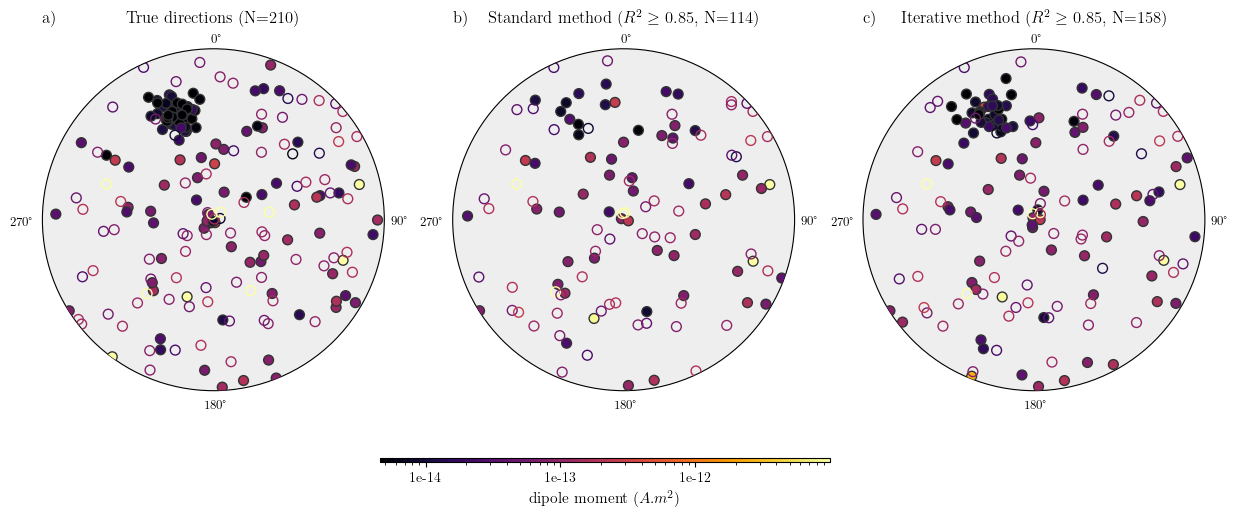

In [57]:
import warnings
warnings.filterwarnings('ignore')

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(15, 5))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, 0.01, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    N1 = dipole_moments.shape[0]
    ax = fig.add_subplot(1, 3, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm
    )    
    tmp = mg.plot_stereonet(dipole_moments, marker="o", zorder=1000, **kwargs, add_ticks=True)  

    #2
    N2 = filter_estimated_d_m.shape[0]
    ax = fig.add_subplot(1, 3, 2, projection='stereonet')
    axes.append(ax) 
    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)
    
    #3
    N3 = filter_estimated_d_m_itr.shape[0]
    ax = fig.add_subplot(1, 3, 3, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    
    titles = (f'True directions  (N={N1})'+'\n', 
              f'Standard method  ($R^2 \geq 0.85$, N={N2})'+'\n',
              f'Iterative method ($R^2 \geq 0.85$, N={N3})'+'\n')

    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.0, 1.0775, f"{letter})", transform=ax.transAxes, fontsize=12)
        ax.set_title(title, fontsize=12)
        ax.grid(False)
        # ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.2, hspace=0.0)
    fig.savefig(fig_dir / "synthetic-data-stereograms-comparison.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

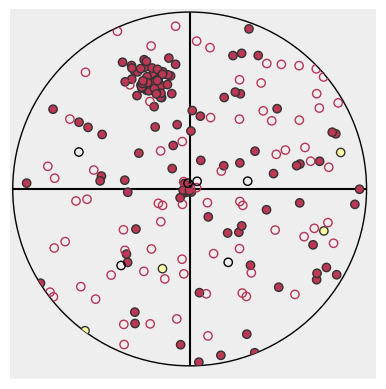

In [58]:
import numpy as np
import matplotlib.pyplot as plt

def equal_area_projection(vectors):
    # Calculate the unitary vector
    norm = np.linalg.norm(vectors, axis=1)
    
    vectors_unitary = np.zeros_like(vectors)
    vectors_unitary[:,0] = vectors[:,0]/norm
    vectors_unitary[:,1] = vectors[:,1]/norm
    vectors_unitary[:,2] = vectors[:,2]/norm

    inclinations, declinations, amplitudes = mg.vector_to_angles(vectors) 
          
    XY_projected = np.zeros( (len(vectors),3) )
    for i, projected_vector in enumerate(vectors_unitary):
        
        r = np.sqrt(1-np.abs(vectors_unitary[i,2]))/np.sqrt(vectors_unitary[i,0]**2+vectors_unitary[i,1]**2)
        
        XY_projected[i, 0] = r*vectors_unitary[i,1]
        XY_projected[i, 1] = r*vectors_unitary[i,0]

        if inclinations[i] >= 0:
            XY_projected[i, 2] = amplitudes[i]
        else:
            XY_projected[i, 2] = -amplitudes[i]

    return XY_projected

def plot_stereographic_projection(vectors, ax=None, cmap="inferno", cmap_norm=plt.Normalize, vmin=None, vmax=None, label=""):
    """
    Função que desenha a projeção estereográfica de Schmidt, com grande círculo e cruz no centro,
    e plota o ponto projetado de acordo com o mergulho e o rumo.
    
    Parameters:
    plunge (float): O mergulho do ponto a ser plotado em graus.
    bearing (float): O rumo do ponto a ser plotado em graus.
    """
    # Criar uma nova figura e eixo
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        
    facecolor = ax.set_facecolor("#eeeeee") # color "#eeeeee"
    ax.grid(linestyle="-", color="#cccccc", linewidth=1)
    
    # Desenhar o grande círculo (bordas da projeção)
    circle = plt.Circle((0, 0), 1, color='black', fill=False)
    clip_path = plt.Circle((0, 0), 1, transform=ax.transData)
    ax.add_artist(circle)
    
    # Desenhar a cruz no centro
    hline = ax.axhline(y=0, xmin=-1, xmax=1, color='black', zorder=-1)
    hline.set_clip_path(clip_path)
    vline = ax.axvline(x=0, ymin=-1, ymax=1, color='black', zorder=-1)
    vline.set_clip_path(clip_path)
    # Realizar a projeção estereográfica de Schmidt
    XY_projected = equal_area_projection(vectors)


    # Generate colors based on the amplitude values
    norm = cmap_norm(vmin=vmin, vmax=vmax)
    colors = plt.colormaps[cmap](norm(XY_projected[:,2]))
    
    # Plotar o ponto projetado
    positive_inc = XY_projected[:,2]>0
    scatter = ax.scatter(XY_projected[:,1][positive_inc],  XY_projected[:,0][positive_inc], 
                         c=colors[positive_inc],
                         label=f"{label}$I > 0$",
                         edgecolors="#333333",)
                         # **kwargs)
    scatter.set_clip_path(clip_path)
    scatter = ax.scatter(XY_projected[:,1][~positive_inc], XY_projected[:,0][~positive_inc],
                        c="#ffffff00",
                        label=f"{label}$I \le 0$",
                        edgecolors=colors[~positive_inc],)
                        # **kwargs)
    scatter.set_clip_path(clip_path)
    
    # Configurar a escala e os limites dos eixos
    ax.set_aspect('equal')
    
    # Remover os eixos
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_clip_path(clip_path)
    for spine in ax.spines.values():
        spine.set_visible(False)

    mappable = plt.cm.ScalarMappable(norm, cmap=cmap)
    return mappable

# Exemplo de uso
plot_stereographic_projection(dipole_moments)


In [59]:
def plot_stereographic_projection(vectors, ax=None, cmap="inferno", cmap_norm=plt.Normalize, vmin=None, vmax=None, label="", **kwargs):
    """
    Função que desenha a projeção estereográfica de Schmidt, com grande círculo e cruz no centro,
    e plota o ponto projetado de acordo com o mergulho e o rumo.
    """
    # Create new figure and axis
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)

    # Add a face color
    background_circle = plt.Circle((0, 0), 1, color="#eeeeee", zorder=-2)  # zorder para colocar atrás dos pontos
    ax.add_artist(background_circle)

    # Draw the great circle
    circle = plt.Circle((0, 0), 1, color='black', fill=False, zorder=3)
    ax.add_artist(circle)
    
    # Define the clipping area
    clip_path = plt.Circle((0, 0), 1, transform=ax.transData)
    
    # Draw the central cross
    hline = ax.axhline(y=0, color='black', zorder=-1)
    hline.set_clip_path(clip_path)
    vline = ax.axvline(x=0, color='black', zorder=-1)
    vline.set_clip_path(clip_path)
    
    # Calculate the equal area projection
    XY_projected = equal_area_projection(vectors)

    # Genearte colors based on the amplitude values
    norm = cmap_norm(vmin=vmin, vmax=vmax)
    colors = plt.colormaps[cmap](norm(abs(XY_projected[:, 2])))
    
    # Plotting the data
    positive_inc = XY_projected[:, 2] > 0
    scatter_pos = ax.scatter(XY_projected[:, 1][positive_inc], XY_projected[:, 0][positive_inc], 
                             c=colors[positive_inc], edgecolors="#333333", label=f"{label}$I > 0$",
                            **kwargs)
    scatter_pos.set_clip_path(clip_path)
    
    scatter_neg = ax.scatter(XY_projected[:, 1][~positive_inc], XY_projected[:, 0][~positive_inc],
                             c="#ffffff00", edgecolors=colors[~positive_inc], label=f"{label}$I \le 0$",
                            **kwargs)
    scatter_neg.set_clip_path(clip_path)
    
    # Configure the axis
    ax.set_aspect('equal')
    
    # Remove axes and box
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # colormap (if necessary)
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    return mappable


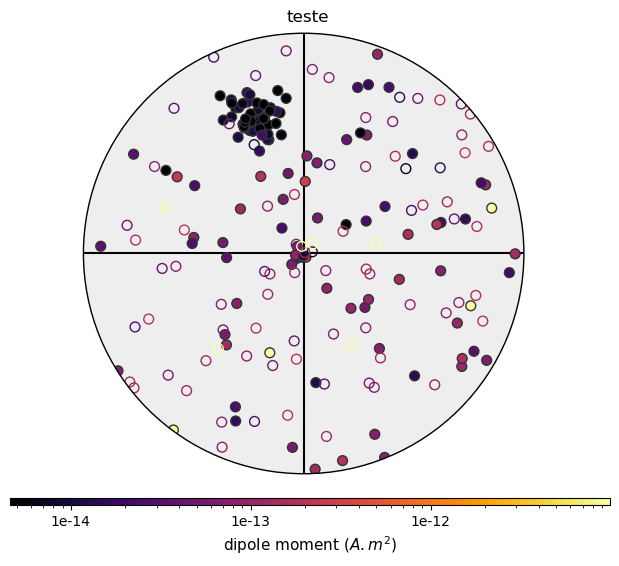

In [60]:
kwargs = dict(
    vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm
)   


fig = plt.figure(figsize=(20, 10))
axes = []

ax = fig.add_subplot(1, 3, 1)
axes.append(ax)  
tmp = plot_stereographic_projection(dipole_moments, ax=ax, **kwargs)
clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.09, 0.25, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
clb.ax.tick_params(labelsize=10)
ax.set_title('teste')
plt.show()


In [61]:
import numpy as np
import matplotlib.pyplot as plt

class StereographicProjection:
    def __init__(self, vectors):
        self.vectors = vectors

    def vector_to_angles(self, vector):
        """
        Generate inclination, declination, and amplitude from a 3-component vector

        Inclination is positive downwards and declination is the angle with the y
        component. The vector has x, y, and z (upward) Cartesian components.

        Parameters
        ----------
        vector : 1D or 2D array
            The x, y, z vector components. Can be a 1D array for a single vector
            or 2D for multiple. If 2D, then each vector should be a row of the
            array.

        Returns
        -------
        inclination : float or array
            The inclination values in degrees.
        declination : float or array
            The declination values in degrees.
        amplitude : float or array
            The vector amplitude values.
        """
        vector = np.asarray(vector)
        x, y, z = vector.T
        amplitude = np.sqrt(x**2 + y**2 + z**2)
        inclination = -np.degrees(np.arctan2(z, np.hypot(x, y)))
        declination = np.degrees(np.arctan2(x, y))
        return inclination, declination, amplitude

    def angles_to_vector(self, inclination, declination, amplitude):
        """
        Generate a 3-component vector from inclination, declination, and amplitude

        Inclination is positive downwards and declination is the angle with the y
        component. The vector has x, y, and z (upward) Cartesian components.

        Parameters
        ----------
        inclination : float or array
            The inclination values in degrees.
        declination : float or array
            The declination values in degrees.
        amplitude : float or array
            The vector amplitude values.

        Returns
        -------
        vector : 1D or 2D array
            The calculated x, y, z vector components. 1D if it's a single vector.
            If N vectors are calculated, the "vector" will have shape (N, 3) with
            each vector in a row of the array.
        """
        inclination = np.radians(inclination)
        declination = np.radians(declination)
        amplitude = np.asarray(amplitude)
        sin_inc = np.sin(-inclination)
        cos_inc = np.cos(-inclination)
        sin_dec = np.sin(declination)
        cos_dec = np.cos(declination)
        x = cos_inc * sin_dec * amplitude
        y = cos_inc * cos_dec * amplitude
        z = sin_inc * amplitude
        return np.transpose([x, y, z])

    def equal_area_projection(self):
        norm = np.linalg.norm(self.vectors, axis=1)
        vectors_unitary = self.vectors / norm[:, np.newaxis]
        inclinations, declinations, amplitudes = self.vector_to_angles(self.vectors)

        XY_projected = np.zeros((len(self.vectors), 3))
        for i, projected_vector in enumerate(vectors_unitary):
            r = np.sqrt(1 - np.abs(vectors_unitary[i, 2])) / np.sqrt(vectors_unitary[i, 0]**2 + vectors_unitary[i, 1]**2)
            XY_projected[i, 0] = r * vectors_unitary[i, 1]
            XY_projected[i, 1] = r * vectors_unitary[i, 0]
            XY_projected[i, 2] = amplitudes[i] if inclinations[i] >= 0 else -amplitudes[i]

        return XY_projected

    def plot(self, ax=None, cmap="inferno", cmap_norm=plt.Normalize, vmin=None, vmax=None, 
             label="", s=50, draw_cross=True, add_radial_grid=True,
             **kwargs):
        """
        Draw the stereographic projection, with optional central cross.
        """
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)

        # Add a face color
        background_circle = plt.Circle((0, 0), 1, color="#eeeeee", zorder=-2)
        ax.add_artist(background_circle)

        # Draw the great circle
        circle = plt.Circle((0, 0), 1, color='black', fill=False, zorder=3)
        ax.add_artist(circle)

        # Define the clipping area
        clip_path = plt.Circle((0, 0), 1, transform=ax.transData)

        # Draw the central cross if requested
        if draw_cross:
            hline = ax.axhline(y=0, color='black', zorder=-1)
            hline.set_clip_path(clip_path)
            vline = ax.axvline(x=0, color='black', zorder=-1)
            vline.set_clip_path(clip_path)


        # Draw the radial grid if requested
        if add_radial_grid:
            for rad_dec in range(0, 360, 10):  # Grid lines every 15 degrees
                rad_inc = np.linspace(0, 85, 90)  # Inclinations from 0 to 90 degrees
                rad_int = np.ones_like(rad_inc)  # Constant amplitude for the grid lines

                # Generate the radial vectors
                radial_vector = self.angles_to_vector(rad_inc, rad_dec, rad_int)

                # Project the radial vectors
                radial_projected = equal_area_projection(radial_vector)

                # Plot each radial grid line
                ax.plot(radial_projected[:, 1], radial_projected[:, 0], color='gray', zorder=-1, lw=0.5)
            for circ_inc in range(0, 90, 10):
                circ_dec = np.linspace(0, 360)  # Inclinations from 0 to 90 degrees
                circ_int = np.ones_like(circ_dec)  # Constant amplitude for the grid lines

                # Generate the radial vectors
                circle_vector = self.angles_to_vector(circ_inc, circ_dec, circ_int)
                # Project the radial vectors
                circle_projected = equal_area_projection(circle_vector)

                # Plot each radial grid line
                ax.plot(circle_projected[:, 1], circle_projected[:, 0], color='gray', zorder=-1, lw=0.5)
        
        # Calculate the equal area projection
        XY_projected = self.equal_area_projection()

        # Generate colors based on the amplitude values
        norm = cmap_norm(vmin=vmin, vmax=vmax)
        colors = plt.colormaps[cmap](norm(abs(XY_projected[:, 2])))

        # Plotting the data
        positive_inc = XY_projected[:, 2] > 0
        scatter_pos = ax.scatter(XY_projected[:, 1][positive_inc], XY_projected[:, 0][positive_inc], 
                                 c=colors[positive_inc], edgecolors="#333333", label=f"{label}$I > 0$",
                                **kwargs)
        scatter_pos.set_clip_path(clip_path)

        scatter_neg = ax.scatter(XY_projected[:, 1][~positive_inc], XY_projected[:, 0][~positive_inc],
                                 c="#ffffff00", edgecolors=colors[~positive_inc], label=f"{label}$I \le 0$",
                                **kwargs)
        scatter_neg.set_clip_path(clip_path)

        # Configure the axis
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)

        # Colormap (if necessary)
        mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        return mappable


In [62]:
import numpy as np
import matplotlib.pyplot as plt

def vector_to_angles(vector):
    """
    Generate inclination, declination, and amplitude from a 3-component vector

    Inclination is positive downwards and declination is the angle with the y
    component. The vector has x, y, and z (upward) Cartesian components.

    Parameters
    ----------
    vector : 1D or 2D array
        The x, y, z vector components. Can be a 1D array for a single vector
        or 2D for multiple. If 2D, then each vector should be a row of the
        array.

    Returns
    -------
    inclination : float or array
        The inclination values in degrees.
    declination : float or array
        The declination values in degrees.
    amplitude : float or array
        The vector amplitude values.
    """
    vector = np.asarray(vector)
    x, y, z = vector.T
    amplitude = np.sqrt(x**2 + y**2 + z**2)
    inclination = -np.degrees(np.arctan2(z, np.hypot(x, y)))
    declination = np.degrees(np.arctan2(x, y))
    return inclination, declination, amplitude

def angles_to_vector(inclination, declination, amplitude):
    """
    Generate a 3-component vector from inclination, declination, and amplitude

    Inclination is positive downwards and declination is the angle with the y
    component. The vector has x, y, and z (upward) Cartesian components.

    Parameters
    ----------
    inclination : float or array
        The inclination values in degrees.
    declination : float or array
        The declination values in degrees.
    amplitude : float or array
        The vector amplitude values.

    Returns
    -------
    vector : 1D or 2D array
        The calculated x, y, z vector components. 1D if it's a single vector.
        If N vectors are calculated, the "vector" will have shape (N, 3) with
        each vector in a row of the array.
    """
    inclination = np.radians(inclination)
    declination = np.radians(declination)
    amplitude = np.asarray(amplitude)
    sin_inc = np.sin(-inclination)
    cos_inc = np.cos(-inclination)
    sin_dec = np.sin(declination)
    cos_dec = np.cos(declination)
    x = cos_inc * sin_dec * amplitude
    y = cos_inc * cos_dec * amplitude
    z = sin_inc * amplitude
    return np.transpose([x, y, z])

def equal_area_projection(vectors):
    norm = np.linalg.norm(vectors, axis=1)
    vectors_unitary = vectors / norm[:, np.newaxis]
    inclinations, declinations, amplitudes = vector_to_angles(vectors)

    XY_projected = np.zeros((len(vectors), 3))
    for i, projected_vector in enumerate(vectors_unitary):
        r = np.sqrt(1 - np.abs(vectors_unitary[i, 2])) / np.sqrt(vectors_unitary[i, 0]**2 + vectors_unitary[i, 1]**2)
        XY_projected[i, 0] = r * vectors_unitary[i, 1]
        XY_projected[i, 1] = r * vectors_unitary[i, 0]
        XY_projected[i, 2] = amplitudes[i] if inclinations[i] >= 0 else -amplitudes[i]

    return XY_projected



class StereographicProjection:
    def __init__(self, vectors):
        self.vectors = vectors

    def plot(self, ax=None, cmap="inferno", cmap_norm=plt.Normalize, vmin=None, vmax=None, 
             label="", 
             # s=50, 
             add_ticks=True, draw_cross=True, add_radial_grid=True, 
             facecolor="#ffffff00", add_legend=False,
             **kwargs):
        """
        Draw the stereographic projection
        """
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)

        # Add a face color
        background_circle = plt.Circle((0, 0), 1, color=facecolor, zorder=-2)
        ax.add_artist(background_circle)

        # Draw the great circle
        circle = plt.Circle((0, 0), 1, color='black', fill=False, zorder=3)
        ax.add_artist(circle)

        # Define the clipping area
        clip_path = plt.Circle((0, 0), 1, transform=ax.transData)

        if add_ticks:
            # Add ticks 
            ax.text(-0.025, 1.05, '0°')
            ax.text(-0.05, -1.075, '180°')
            ax.text(-1.15, -0.025, '270°')
            ax.text(1.025, -0.025, '90°')
        
        if label and not label.endswith(" "):
            label = label + " "
            # Draw the central cross if requested
            if draw_cross:
                hline = ax.axhline(y=0, color='black', zorder=-1)
                hline.set_clip_path(clip_path)
                vline = ax.axvline(x=0, color='black', zorder=-1)
                vline.set_clip_path(clip_path)


        # Draw the radial grid
        if add_radial_grid:
            for rad_dec in range(0, 360, 10):  # Grid lines every 10 degrees
                rad_inc = np.linspace(0, 90, 1000)  # Inclinations from 0 to 90 degrees
                # rad_int = np.ones_like(rad_inc)  # Constant amplitude for the grid lines

                # Generate the radial vectors
                radial_vector = angles_to_vector(rad_inc, rad_dec, 1)

                # Project the radial vectors
                radial_projected = equal_area_projection(radial_vector)

                # Plot each radial grid line
                ax.plot(radial_projected[:, 1], radial_projected[:, 0], color='gray', zorder=-2, lw=0.5)
            for circ_inc in range(0, 90, 10):
                circ_dec = np.linspace(0, 360, 1000)  # Inclinations from 0 to 90 degrees
                circ_int = np.ones_like(circ_dec)  # Constant amplitude for the grid lines

                # Generate the radial vectors
                circle_vector = angles_to_vector(circ_inc, circ_dec, circ_int)
                # Project the radial vectors
                circle_projected = equal_area_projection(circle_vector)

                # Plot each radial grid line
                ax.plot(circle_projected[:, 1], circle_projected[:, 0], color='gray', zorder=-2, lw=0.5)
        
        # Calculate the equal area projection
        XY_projected = equal_area_projection(self.vectors)

        # Generate colors based on the amplitude values
        norm = cmap_norm(vmin=vmin, vmax=vmax)
        colors = plt.colormaps[cmap](norm(abs(XY_projected[:, 2])))

        # Plotting the data
        positive_inc = XY_projected[:, 2] > 0
        scatter_pos = ax.scatter(XY_projected[:, 1][positive_inc], XY_projected[:, 0][positive_inc], 
                                 c=colors[positive_inc], edgecolors="#333333", label=f"{label}$I > 0$",
                                **kwargs)
        scatter_pos.set_clip_path(clip_path)

        scatter_neg = ax.scatter(XY_projected[:, 1][~positive_inc], XY_projected[:, 0][~positive_inc],
                                 c="#ffffff00", edgecolors=colors[~positive_inc], label=rf"{label}$I \leq 0$",
                                **kwargs)
        scatter_neg.set_clip_path(clip_path)

        # Configure the axis
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        if add_legend:
            ax.legend()
        for spine in ax.spines.values():
            spine.set_visible(False)

        # Colormap (if necessary)
        mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        return mappable


In [117]:
filter = mg.vector_to_angles(dipole_moments)[2]<=1.0e-13

test = np.sum(dipole_moments[filter], axis=0)
test_ang = mg.vector_to_angles(test)
test_ang

(-17.001463434696692, 37.21609731415818, 2.084183636085194e-13)

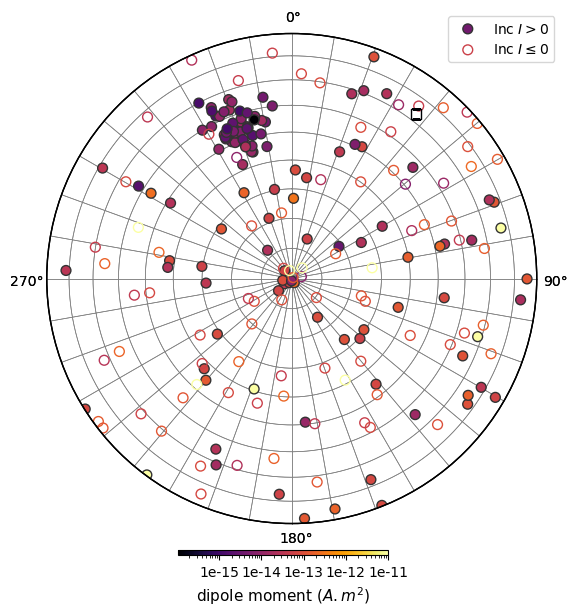

In [118]:
projection = mg.StereographicProjection(dipole_moments)
projection_R = mg.StereographicProjection(np.reshape(test,(1,3)))


kwargs = dict(
    s=50, cmap=cmap, cmap_norm=cmap_norm
)   

# Plota a projeção estereográfica
fig, ax = plt.subplots(figsize=(7,7))
tmp = projection.plot(ax=ax, draw_cross=False, add_radial_grid=True, label="Inc", add_legend=True, **kwargs)
tmp_R = projection_R.plot(ax=ax, marker='s', **kwargs)
clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, 0.1, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
clb.ax.tick_params(labelsize=10)
plt.show()

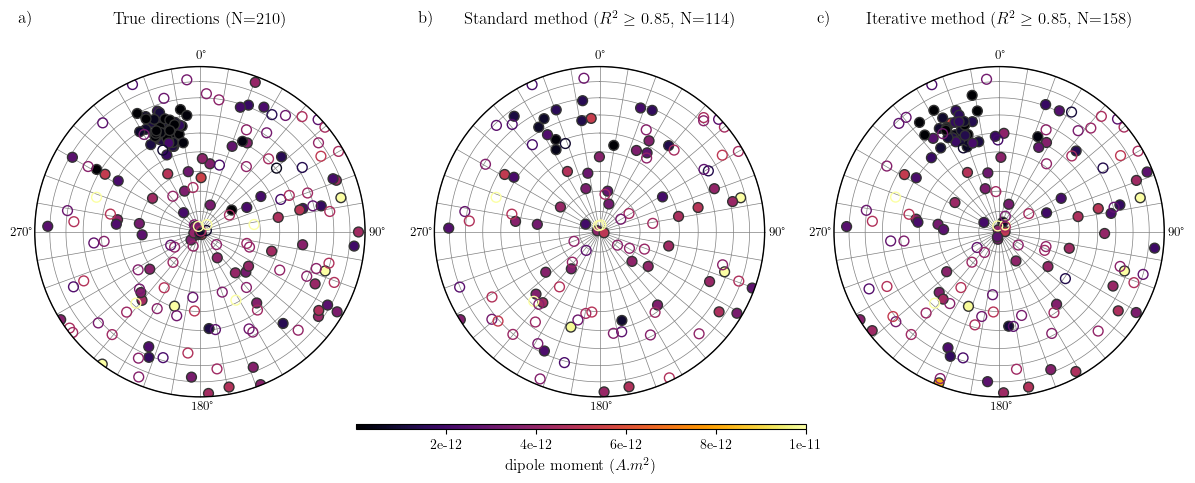

In [64]:
import warnings
warnings.filterwarnings('ignore')

vmin = np.min(estimated)
vmax = np.max(estimated)
cmap = "inferno"
# Use matplotlib.colors.LogNorm for a log scale
cmap_norm = matplotlib.colors.LogNorm #Normalize

kwargs = dict(
    ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm
)    

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(15, 5))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, 0.1, 0.3, 0.01]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    N1 = dipole_moments.shape[0]
    ax = fig.add_subplot(1, 3, 1)
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm
    )    

    projection = StereographicProjection(dipole_moments)
    tmp = projection.plot(draw_cross=True, add_radial_grid=True, **kwargs)

    #2
    N2 = filter_estimated_d_m.shape[0]
    ax = fig.add_subplot(1, 3, 2)
    axes.append(ax) 
    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    projection = StereographicProjection(filter_estimated_d_m)
    tmp = projection.plot(draw_cross=True, add_radial_grid=True, **kwargs)
    
    #3
    N3 = filter_estimated_d_m_itr.shape[0]
    ax = fig.add_subplot(1, 3, 3)
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm
    )    
    projection = StereographicProjection(filter_estimated_d_m_itr)
    tmp = projection.plot(draw_cross=True, add_radial_grid=True, **kwargs)
    
    titles = (f'True directions  (N={N1})'+'\n', 
              f'Standard method  ($R^2 \geq 0.85$, N={N2})'+'\n',
              f'Iterative method ($R^2 \geq 0.85$, N={N3})'+'\n')

    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.0, 1.0775, f"{letter})", transform=ax.transAxes, fontsize=12)
        ax.set_title(title, fontsize=12)
        ax.grid(False)
        # ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.1, hspace=0.0)
    fig.savefig(fig_dir / "synthetic-data-stereograms-comparison.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

In [65]:
teste = angles_to_vector([0, 0, 0, 0], [0, 90, 180, 270], [1,1,1,1])
np.round(teste)

array([[ 0.,  1., -0.],
       [ 1.,  0., -0.],
       [ 0., -1., -0.],
       [-1., -0., -0.]])

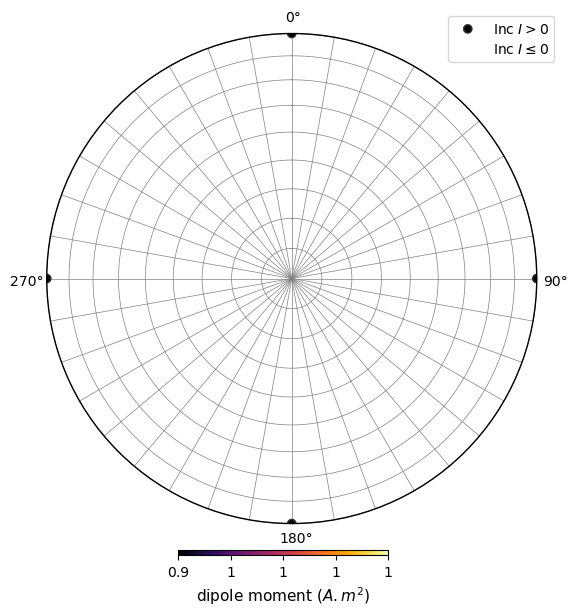

In [66]:
projection = StereographicProjection(teste)

# Plota a projeção estereográfica
fig, ax = plt.subplots(figsize=(7,7))
aaa = projection.plot(ax=ax, draw_cross=False, add_radial_grid=True, label="Inc", add_legend=True)
clb = fig.colorbar(
        aaa, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, 0.1, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
clb.ax.tick_params(labelsize=10)
plt.show()